In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mpd
from pylab import text
import xarray as xr
import rioxarray as rxr
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
from pandas import Timestamp
import statistics

rho = 917 # density of ice, kg/m^3
Ls = 2828000 # J/kg latent heat of sumbimaton of ice at 0 deg C

In [2]:
STATION_df = pd.read_csv("/apollo1/esthapit/NWM_Retro_point/STATION_out_df.csv")
NLDAS_df = pd.read_csv("/apollo1/esthapit/NWM_Retro_point/NLDAS_out_df.csv")
SAFE_F = pd.read_csv("/apollo1/esthapit/NWM_Retro_point/SAFE_F_updated.csv")
NLDAS_F = pd.read_csv(r"/apollo1/esthapit/NWM_Retro_point/NLDAS_F.csv", sep=',', header=0, skipinitialspace=True)
NLDAS_cumppt=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/NLDAS_cumppt.csv")
SAFE_cumppt=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/SAFE_cumppt.csv")
SNOW_st=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/snow_St.csv")

NLDAS_df["Time"]=pd.to_datetime(NLDAS_df["Time"])
STATION_df["Time"]=pd.to_datetime(STATION_df["Time"])
SAFE_F["DATE_TIME_UTC"]=pd.to_datetime(SAFE_F["DATE_TIME_UTC"])
NLDAS_F["Times"]=pd.to_datetime(NLDAS_F["Times"])
NLDAS_cumppt["date"]=pd.to_datetime(NLDAS_cumppt["date"])
SAFE_cumppt["date"]=pd.to_datetime(SAFE_cumppt["date"])
SNOW_st["Date"]=pd.to_datetime(SNOW_st["Date"])

STATION_df['SWUP']=STATION_df['SWUP'].mask(STATION_df['SWUP'].lt(0),0)
STATION_df['LWUP']=STATION_df['LWUP'].mask(STATION_df['LWUP'].lt(0),0)

NLDAS_df['FSA']=NLDAS_df['FSA'].mask(NLDAS_df['FSA'].lt(0),0)
STATION_df['FSA']=STATION_df['FSA'].mask(STATION_df['FSA'].lt(0),0)

STATION_df['ALBEDO']=STATION_df['ALBEDO'].mask(STATION_df['ALBEDO'].lt(0),0)
STATION_df['ALBEDO']=STATION_df['ALBEDO'].mask(STATION_df['ALBEDO'].gt(1),1)

SAFE_F['SR01Up_Avg']=SAFE_F['SR01Up_Avg'].mask(SAFE_F['SR01Up_Avg'].lt(2),0)
SAFE_F['RH[%]']=SAFE_F['RH[%]'].mask(SAFE_F['RH[%]'].lt(25),'NaN')

In [9]:
SAFE_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     52584 non-null  int64         
 1   DATE_TIME_UTC  52584 non-null  datetime64[ns]
 2   DATE_TIME_EST  52584 non-null  object        
 3   AIR_T[C]       51528 non-null  float64       
 4   WSPD[m/s]      51528 non-null  float64       
 5   RH[%]          51528 non-null  object        
 6   SR01Up_Avg     37824 non-null  float64       
 7   IR01UpCo_Avg   37824 non-null  float64       
 8   SR01Dn_Avg     37824 non-null  float64       
 9   IR01DnCo_Avg   37824 non-null  float64       
 10  Albedo_Avg     6290 non-null   float64       
 11  PR01[m]        51528 non-null  float64       
 12  PR01[mm/s]     51528 non-null  float64       
 13  AIR_T[K]       51528 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(2)
memory usage: 5

In [5]:
NLDAS_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    52584 non-null  int64         
 1   LWDOWN        52584 non-null  float64       
 2   PSFC          52584 non-null  float64       
 3   Q2D           52584 non-null  float64       
 4   RAINRATE      52584 non-null  float64       
 5   SWDOWN        52584 non-null  float64       
 6   T2D           52584 non-null  float64       
 7   Times         52584 non-null  datetime64[ns]
 8   U2D           52584 non-null  float64       
 9   V2D           52584 non-null  float64       
 10  valid time    52584 non-null  int64         
 11  year          52584 non-null  int64         
 12  month         52584 non-null  int64         
 13  day           52584 non-null  int64         
 14  hour          52584 non-null  int64         
 15  Rain(m)       52584 non-null  float6

In [6]:
NLDAS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  52584 non-null  int64         
 1   Time        52584 non-null  datetime64[ns]
 2   SNOWH       52584 non-null  float64       
 3   SNEQV       52584 non-null  float64       
 4   ALBEDO      52570 non-null  float64       
 5   FSNO        52583 non-null  float64       
 6   FSA         52583 non-null  float64       
 7   FIRA        52583 non-null  float64       
 8   TRAD        52583 non-null  float64       
 9   LWUP        52583 non-null  float64       
 10  SWUP        52583 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 4.4 MB


In [8]:
STATION_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  52584 non-null  int64         
 1   Time        52584 non-null  datetime64[ns]
 2   SNOWH       52584 non-null  float64       
 3   SNEQV       52584 non-null  float64       
 4   ALBEDO      52570 non-null  float64       
 5   FSNO        52583 non-null  float64       
 6   FIRA        52583 non-null  float64       
 7   FSA         52583 non-null  float64       
 8   TRAD        52583 non-null  float64       
 9   LWUP        37823 non-null  float64       
 10  SWUP        37823 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 4.4 MB


In [3]:
STATION_11_18_df=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/STATION_11_18_df.csv")
STATION_11_18_df=STATION_11_18_df.loc[552:719,:]
STATION_11_18_df=STATION_11_18_df.reset_index()
STATION_11_18_df["dSWE_sublime"]=(STATION_11_18_df.loc[:,"LH"]/(rho * Ls))*3600*1000
STATION_11_18_df["dSWE_sublime_updated"]=STATION_11_18_df["dSWE_sublime"].mask(STATION_11_18_df['dSWE_sublime'].lt(0),0)
STATION_11_18_df["dSWE_sublime_cum"]=STATION_11_18_df["dSWE_sublime_updated"].cumsum()
STATION_11_18_df["dSWE_sublime_cum_zeroed"]=STATION_11_18_df["dSWE_sublime_cum"]-0
STATION_11_18_df["dSWE_sublime_cum_zeroed"]=STATION_11_18_df["dSWE_sublime_cum_zeroed"].mask(STATION_11_18_df['dSWE_sublime_cum_zeroed'].lt(0.000002),0)
FSA = STATION_df.loc[42912:43079,"FSA"].reset_index()
STATION_11_18_df["FSA"]=FSA["FSA"]
FIRA = STATION_df.loc[42912:43079,"FIRA"].reset_index()
STATION_11_18_df["FIRA"]=FIRA["FIRA"]
STATION_11_18_df["Tot_Energy"]=STATION_11_18_df["FSA"]+(-1)*STATION_11_18_df["FIRA"]+STATION_11_18_df["LH"]*(-1)+STATION_11_18_df["HFX"]*(-1)
STATION_11_18_df["Time"]=pd.to_datetime(STATION_11_18_df["Time"])
STATION_11_18_df

STATION_12_18_df=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/STATION_12_18_df.csv")
STATION_12_18_df=STATION_12_18_df.loc[432:599,:]
STATION_12_18_df=STATION_12_18_df.reset_index()
STATION_12_18_df["dSWE_sublime"]=(STATION_12_18_df["LH"]/(rho * Ls))*3600*1000
STATION_12_18_df["dSWE_sublime_updated"]=STATION_12_18_df["dSWE_sublime"].mask(STATION_12_18_df['dSWE_sublime'].lt(0),0)
STATION_12_18_df["dSWE_sublime_cum"]=STATION_12_18_df["dSWE_sublime_updated"].cumsum()
STATION_12_18_df["dSWE_sublime_cum_zeroed"]=STATION_12_18_df["dSWE_sublime_cum"]-0.0
STATION_12_18_df["dSWE_sublime_cum_zeroed"]=STATION_12_18_df["dSWE_sublime_cum_zeroed"].mask(STATION_12_18_df['dSWE_sublime_cum_zeroed'].lt(0),0)
FSA = STATION_df.loc[43512:43679,"FSA"].reset_index()
STATION_12_18_df["FSA"]=FSA["FSA"]
FIRA = STATION_df.loc[43512:43679,"FIRA"].reset_index()
STATION_12_18_df["FIRA"]=FIRA["FIRA"]
STATION_12_18_df["Tot_Energy"]=STATION_12_18_df["FSA"]+(-1)*STATION_12_18_df["FIRA"]+STATION_12_18_df["LH"]*(-1)+STATION_12_18_df["HFX"]*(-1)
STATION_12_18_df["Time"]=pd.to_datetime(STATION_12_18_df["Time"])
STATION_12_18_df

NLDAS_11_18_df=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/NLDAS_11_18_df.csv")
NLDAS_11_18_df=NLDAS_11_18_df.loc[552:719,:]
NLDAS_11_18_df=NLDAS_11_18_df.reset_index()
NLDAS_11_18_df["dSWE_sublime"]=(NLDAS_11_18_df["LH"]/(rho * Ls))*3600*1000
NLDAS_11_18_df["dSWE_sublime_updated"]=NLDAS_11_18_df["dSWE_sublime"].mask(NLDAS_11_18_df['dSWE_sublime'].lt(0),0)
NLDAS_11_18_df["dSWE_sublime_cum"]=NLDAS_11_18_df["dSWE_sublime_updated"].cumsum()
NLDAS_11_18_df["dSWE_sublime_cum_zeroed"]=NLDAS_11_18_df["dSWE_sublime_cum"]-0.0
NLDAS_11_18_df["dSWE_sublime_cum_zeroed"]=NLDAS_11_18_df["dSWE_sublime_cum_zeroed"].mask(NLDAS_11_18_df['dSWE_sublime_cum_zeroed'].lt(0),0)
FSA = NLDAS_df.loc[42912:43079,"FSA"].reset_index()
NLDAS_11_18_df["FSA"]=FSA["FSA"]
FIRA = NLDAS_df.loc[42912:43079,"FIRA"].reset_index()
NLDAS_11_18_df["FIRA"]=FIRA["FIRA"]
NLDAS_11_18_df["Tot_Energy"]=NLDAS_11_18_df["FSA"]+(-1)*NLDAS_11_18_df["FIRA"]+(-1.0)*NLDAS_11_18_df["LH"]+(-1.0)*NLDAS_11_18_df["HFX"]
NLDAS_11_18_df["Time"]=pd.to_datetime(NLDAS_11_18_df["Time"])
NLDAS_11_18_df

NLDAS_12_18_df=pd.read_csv("/apollo1/esthapit/NWM_Retro_point/NLDAS_12_18_df.csv")
NLDAS_12_18_df=NLDAS_12_18_df.loc[432:599,:]
NLDAS_12_18_df=NLDAS_12_18_df.reset_index()
NLDAS_12_18_df["dSWE_sublime"]=(NLDAS_12_18_df["LH"]/(rho * Ls))*3600*1000
NLDAS_12_18_df["dSWE_sublime_updated"]=NLDAS_12_18_df["dSWE_sublime"].mask(NLDAS_12_18_df['dSWE_sublime'].lt(0),0)
NLDAS_12_18_df["dSWE_sublime_cum"]=NLDAS_12_18_df["dSWE_sublime_updated"].cumsum()
NLDAS_12_18_df["dSWE_sublime_cum_zeroed"]=NLDAS_12_18_df["dSWE_sublime_cum"]-0.0
NLDAS_12_18_df["dSWE_sublime_cum_zeroed"]=NLDAS_12_18_df["dSWE_sublime_cum_zeroed"].mask(NLDAS_12_18_df['dSWE_sublime_cum_zeroed'].lt(0),0)
FSA = NLDAS_df.loc[43512:43679,"FSA"].reset_index()
NLDAS_12_18_df["FSA"]=FSA["FSA"]
FIRA = NLDAS_df.loc[43512:43679,"FIRA"].reset_index()
NLDAS_12_18_df["FIRA"]=FIRA["FIRA"]
NLDAS_12_18_df["Tot_Energy"]=NLDAS_12_18_df["FSA"]+(-1)*NLDAS_12_18_df["FIRA"]+(-1.0)*NLDAS_12_18_df["LH"]+(-1.0)*NLDAS_12_18_df["HFX"] #+NLDAS_df.loc[43512:43679,"FIRA"] #+NLDAS_12_18_df.loc[:,"LH"]+NLDAS_12_18_df.loc[:,"HFX"]
NLDAS_12_18_df["Time"]=pd.to_datetime(NLDAS_12_18_df["Time"])
NLDAS_12_18_df

,index,Unnamed: 0,Time,HFX,LH,dSWE_sublime,dSWE_sublime_updated,dSWE_sublime_cum,dSWE_sublime_cum_zeroed,FSA,FIRA,Tot_Energy
0,432,432,2018-12-19 00:00:00,-20.900000,-1.6,-0.002221,0.0,0.000000,0.000000,0.000000,25.200000,-2.7
1,433,433,2018-12-19 01:00:00,-20.400000,-1.7,-0.002360,0.0,0.000000,0.000000,0.000000,24.700000,-2.6
2,434,434,2018-12-19 02:00:00,-19.800000,-1.8,-0.002499,0.0,0.000000,0.000000,0.000000,24.200000,-2.6
3,435,435,2018-12-19 03:00:00,-33.700001,-6.0,-0.008329,0.0,0.000000,0.000000,0.000000,44.600001,-4.9
4,436,436,2018-12-19 04:00:00,-31.300000,-6.3,-0.008746,0.0,0.000000,0.000000,0.000000,42.300001,-4.7
...,...,...,...,...,...,...,...,...,...,...,...,...
163,595,595,2018-12-25 19:00:00,-21.100000,-4.7,-0.006525,0.0,0.335252,0.335252,43.600001,85.800001,-16.4
164,596,596,2018-12-25 20:00:00,-27.200000,-6.3,-0.008746,0.0,0.335252,0.335252,19.000000,75.900001,-23.4
165,597,597,2018-12-25 21:00:00,-32.900000,-7.2,-0.009995,0.0,0.335252,0.335252,0.000000,70.900001,-30.8
166,598,598,2018-12-25 22:00:00,-36.300001,-7.6,-0.010550,0.0,0.335252,0.335252,0.000000,64.800001,-20.9


In [17]:
STATION_11_18_df.to_csv("STATION_11_18_df.csv")

In [24]:
NLDAS_11_18_df

,Unnamed: 0,Time,HFX,LH,dSWE_sublime,dSWE_sublime_updated,dSWE_sublime_cum,dSWE_sublime_cum_zeroed
552,552,2018-11-24 00:00:00,-23.9,-6.0,-0.008329,0.0,0.000000,0.000000
553,553,2018-11-24 01:00:00,-22.4,-5.5,-0.007635,0.0,0.000000,0.000000
554,554,2018-11-24 02:00:00,-21.2,-5.1,-0.007080,0.0,0.000000,0.000000
555,555,2018-11-24 03:00:00,-11.1,-3.0,-0.004165,0.0,0.000000,0.000000
556,556,2018-11-24 04:00:00,-10.8,-3.0,-0.004165,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
715,715,2018-11-30 19:00:00,-6.6,-3.3,-0.004581,0.0,0.533071,0.533071
716,716,2018-11-30 20:00:00,-9.9,-4.6,-0.006386,0.0,0.533071,0.533071
717,717,2018-11-30 21:00:00,-14.0,-5.4,-0.007496,0.0,0.533071,0.533071
718,718,2018-11-30 22:00:00,-14.6,-5.3,-0.007357,0.0,0.533071,0.533071


In [224]:
STATION_11_18_df

,index,Unnamed: 0,Time,HFX,LH,dSWE_sublime,dSWE_sublime_updated,dSWE_sublime_cum,dSWE_sublime_cum_zeroed,FSA,FIRA,Tot_Energy
0,552,552,2018-11-24 00:00:00,-20.3,-0.7,-0.000972,0.000000,0.000000,0.000000,0.000000,28.300000,-7.3
1,553,553,2018-11-24 01:00:00,-12.8,3.2,0.004442,0.004442,0.004442,0.004442,0.000000,3.600000,6.0
2,554,554,2018-11-24 02:00:00,-12.2,3.2,0.004442,0.004442,0.008885,0.008885,0.000000,8.300000,0.7
3,555,555,2018-11-24 03:00:00,-8.0,6.4,0.008885,0.008885,0.017769,0.017769,0.000000,-1.700000,3.3
4,556,556,2018-11-24 04:00:00,-6.0,8.6,0.011939,0.011939,0.029708,0.029708,0.000000,-4.200000,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
163,715,715,2018-11-30 19:00:00,-3.1,5.0,0.006941,0.006941,1.158319,1.158319,53.400001,52.900001,-1.4
164,716,716,2018-11-30 20:00:00,-2.0,2.9,0.004026,0.004026,1.162344,1.162344,51.800001,52.500001,-1.6
165,717,717,2018-11-30 21:00:00,-1.1,2.3,0.003193,0.003193,1.165537,1.165537,48.200001,50.100001,-3.1
166,718,718,2018-11-30 22:00:00,-6.2,-1.8,-0.002499,0.000000,1.165537,1.165537,0.000000,26.800000,-18.8


In [5]:
T0 = 273.15
EP = 0.622
ONEMEP = 0.378
ESO = 6.11
A = 17.269
B = 35.86

column_names=["EST","QST","QW", "RH"]
NLDAS_F1 = pd.DataFrame(columns = column_names)
NLDAS_F1["EST"] = ESO * np.exp((A * (NLDAS_F["T2D"]-T0))/(NLDAS_F["T2D"]-B))
NLDAS_F1["QST"] = EP * NLDAS_F1["EST"]/(NLDAS_F['PSFC']*0.01-ONEMEP * NLDAS_F1["EST"])
NLDAS_F1["QW"] = NLDAS_F["Q2D"] / (1-NLDAS_F["Q2D"])
NLDAS_F1["RH"] = NLDAS_F1["QW"]/(NLDAS_F1["QST"]*0.01)
NLDAS_F1

,EST,QST,QW,RH
0,1.120306,0.000700,0.000700,99.999999
1,1.139984,0.000712,0.000712,100.000004
2,1.159972,0.000725,0.000725,100.000000
3,1.180099,0.000737,0.000737,100.000004
4,1.154391,0.000721,0.000721,99.999999
...,...,...,...,...
52579,4.847676,0.003065,0.002847,92.863412
52580,4.825882,0.003055,0.002866,93.815330
52581,4.804011,0.003045,0.002886,94.770979
52582,4.796634,0.003045,0.002881,94.606998


In [4]:
conditions = [NLDAS_F.SWDOWN.eq(0),NLDAS_F.SWDOWN.gt(0)]
choices1 = [0,NLDAS_df["ALBEDO"]]
NLDAS_df["ALBEDO_updated"]=np.select(conditions,choices1)
NLDAS_df["ALBEDO_updated"]=pd.to_numeric(NLDAS_df["ALBEDO_updated"])
choices2 = [0,NLDAS_df["FSA"]]
NLDAS_df["FSA_updated"]=np.select(conditions,choices2)
NLDAS_df["FSA_updated"]=pd.to_numeric(NLDAS_df["FSA_updated"])
NLDAS_df.info()

conditions = [SAFE_F.SR01Up_Avg.lt(0),SAFE_F.SR01Up_Avg.eq(0),SAFE_F.SR01Up_Avg.gt(0)]
choices1 = [0,0,STATION_df["ALBEDO"]]
STATION_df["ALBEDO_updated"]=np.select(conditions,choices1)
STATION_df["ALBEDO_updated"]=pd.to_numeric(STATION_df["ALBEDO_updated"])
choices2 = [0,0,STATION_df["FSA"]]
STATION_df["FSA_updated"]=np.select(conditions,choices2)
STATION_df["FSA_updated"]=pd.to_numeric(STATION_df["FSA_updated"])
STATION_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      52584 non-null  int64         
 1   Time            52584 non-null  datetime64[ns]
 2   SNOWH           52584 non-null  float64       
 3   SNEQV           52584 non-null  float64       
 4   ALBEDO          52570 non-null  float64       
 5   FSNO            52583 non-null  float64       
 6   FSA             52583 non-null  float64       
 7   FIRA            52583 non-null  float64       
 8   TRAD            52583 non-null  float64       
 9   LWUP            52583 non-null  float64       
 10  SWUP            52583 non-null  float64       
 11  ALBEDO_updated  52583 non-null  float64       
 12  FSA_updated     52584 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
Ran

In [128]:
a= STATION_df.loc[0:6551,:] # WY2014
print('SWE max STATION 2014 WY is: {}'.format(a.iloc[a['SNEQV'].argmax()]))
b= STATION_df.loc[6552:15311,:] # WY2015
print('SWE max STATION 2015 WY is: {}'.format(b.iloc[b['SNEQV'].argmax()]))
c= STATION_df.loc[15312:24095,:] # WY2016
print('SWE max STATION 2016 WY is: {}'.format(c.iloc[c['SNEQV'].argmax()]))
d= STATION_df.loc[24096:32855,:] # WY2017
print('SWE max STATION 2017 WY is: {}'.format(d.iloc[d['SNEQV'].argmax()]))
e= STATION_df.loc[32856:41615,:] # WY2018
print('SWE max STATION 2018 WY is: {}'.format(e.iloc[e['SNEQV'].argmax()]))
f= STATION_df.loc[41616:50375,:] # WY2019
print('SWE max STATION 2019 WY is: {}'.format(f.iloc[f['SNEQV'].argmax()]))

a= NLDAS_df.loc[0:6551,:]
print('SWE max NLDAS 2014 WY is: {}'.format(a.iloc[a['SNEQV'].argmax()]))
b= NLDAS_df.loc[6552:15311,:]
print('SWE max NLDAS 2015 WY is: {}'.format(b.iloc[b['SNEQV'].argmax()]))
c= NLDAS_df.loc[15312:24095,:]
print('SWE max NLDAS 2016 WY is: {}'.format(c.iloc[c['SNEQV'].argmax()]))
d= NLDAS_df.loc[24096:32855,:]
print('SWE max NLDAS 2017 WY is: {}'.format(d.iloc[d['SNEQV'].argmax()]))
e= NLDAS_df.loc[32856:41615,:]
print('SWE max NLDAS 2018 WY is: {}'.format(e.iloc[e['SNEQV'].argmax()]))
f= NLDAS_df.loc[41616:50375,:]
print('SWE max NLDAS 2019 WY is: {}'.format(f.iloc[f['SNEQV'].argmax()]))

SWE max STATION 2014 WY is: Unnamed: 0                       2287
Time              2014-04-06 07:00:00
SNOWH                          0.6163
SNEQV                           186.7
ALBEDO                           0.81
FSNO                                1
FIRA                              1.1
FSA                                 0
TRAD                            273.2
LWUP                            315.7
SWUP                                0
ALBEDO_updated                      0
FSA_updated                         0
Name: 2287, dtype: object
SWE max STATION 2015 WY is: Unnamed: 0                       2400
Time              2015-04-11 00:00:00
SNOWH                          0.6181
SNEQV                             208
ALBEDO                           0.85
FSNO                                1
FIRA                             -8.8
FSA                                 0
TRAD                            273.2
LWUP                           315.67
SWUP                                0
ALBEDO

In [130]:
NLDAS_cumppt_wy_2014 = NLDAS_F.loc[0:2289,'Rain(m)'].cumsum() #max SWE on 2014-04-06 09:00:00
NLDAS_cumppt_wy_2015 = NLDAS_F.loc[8016:10713,'Rain(m)'].cumsum()  #max SWE on 2015-03-23 09:00:00
NLDAS_cumppt_wy_2016 = NLDAS_F.loc[16776:19646,'Rain(m)'].cumsum() #max SWE on 2016-03-29 14:00:00
NLDAS_cumppt_wy_2017 = NLDAS_F.loc[25560:28395,'Rain(m)'].cumsum() #max SWE on 2017-03-29 03:00:00
NLDAS_cumppt_wy_2018 = NLDAS_F.loc[34320:37389,'Rain(m)'].cumsum() #max SWE on 2018-04-07 21:00:00
NLDAS_cumppt_wy_2019 = NLDAS_F.loc[43080:45780,'Rain(m)'].cumsum() #max SWE on 2019-03-23 12:00:00

print('Cum_Precip(m) 2014 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2014.loc[2289]))
print('Cum_Precip(m) 2015 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2015.loc[10713]))
print('Cum_Precip(m) 2016 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2016.loc[19646]))
print('Cum_Precip(m) 2017 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2017.loc[28395]))
print('Cum_Precip(m) 2018 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2018.loc[37389]))
print('Cum_Precip(m) 2019 WY NLDAS2 is: {}'.format(NLDAS_cumppt_wy_2019.loc[45780]))
print()
SAFE_cumppt_wy_2014 = SAFE_F.loc[0:2287,'PR01[m]'].cumsum() #max SWE on 2014-04-06 07:00:00
SAFE_cumppt_wy_2015 = SAFE_F.loc[8016:11160,'PR01[m]'].cumsum()  #max SWE on 2015-04-11 00:00:00
SAFE_cumppt_wy_2016 = SAFE_F.loc[16776:19646,'PR01[m]'].cumsum() #max SWE on 2016-03-29 14:00:00
SAFE_cumppt_wy_2017 = SAFE_F.loc[25560:28394,'PR01[m]'].cumsum() #max SWE on 2017-03-29 02:00:00
SAFE_cumppt_wy_2018 = SAFE_F.loc[34320:36836,'PR01[m]'].cumsum() #max SWE on 2018-03-15 20:00:00
SAFE_cumppt_wy_2019 = SAFE_F.loc[43080:45767,'PR01[m]'].cumsum() #max SWE on 2019-03-22 23:00:00

print('Cum_Precip(m) 2014 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2014.loc[2287]))
print('Cum_Precip(m) 2015 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2015.loc[11160]))
print('Cum_Precip(m) 2016 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2016.loc[19646]))
print('Cum_Precip(m) 2017 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2017.loc[28394]))
print('Cum_Precip(m) 2018 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2018.loc[36836]))
print('Cum_Precip(m) 2019 WY SAFE2 is: {}'.format(SAFE_cumppt_wy_2019.loc[45767]))

Cum_Precip(m) 2014 WY NLDAS2 is: 0.22931549633953835
Cum_Precip(m) 2015 WY NLDAS2 is: 0.24664518895785428
Cum_Precip(m) 2016 WY NLDAS2 is: 0.3713718084372077
Cum_Precip(m) 2017 WY NLDAS2 is: 0.3064582037833612
Cum_Precip(m) 2018 WY NLDAS2 is: 0.3659756835611535
Cum_Precip(m) 2019 WY NLDAS2 is: 0.3344013053211782

Cum_Precip(m) 2014 WY SAFE2 is: 0.2538169999999998
Cum_Precip(m) 2015 WY SAFE2 is: 0.31511099999999953
Cum_Precip(m) 2016 WY SAFE2 is: 0.3530479999999995
Cum_Precip(m) 2017 WY SAFE2 is: 0.32477399999999884
Cum_Precip(m) 2018 WY SAFE2 is: 0.3230489999999985
Cum_Precip(m) 2019 WY SAFE2 is: 0.34179099999999923


In [131]:
NLDAS_cumppt_wy_2015

8016     0.000000
8017     0.000000
8018     0.000000
8019     0.000000
8020     0.000000
           ...   
10709    0.246218
10710    0.246645
10711    0.246645
10712    0.246645
10713    0.246645
Name: Rain(m), Length: 2698, dtype: float64

In [5]:
column_names=["Date","SAFE_PR01[m]","SAFE_AIR_T[K]","SAFE_FPICE","SAFE_Snow","SAFE_Rain","SAFE_CumSnow","SAFE_CumRain","NLDAS_Rain(m)","NLDAS_T2D","NLDAS_FPICE","NLDAS_Snow","NLDAS_Rain", "NLDAS_CumSnow","NLDAS_CumRain"]
rainsnow = pd.DataFrame(columns = column_names)
 
rainsnow["Date"] = SAFE_F["DATE_TIME_UTC"]
rainsnow["SAFE_PR01[m]"] = SAFE_F["PR01[m]"]
rainsnow["SAFE_AIR_T[K]"] = SAFE_F["AIR_T[K]"]

rainsnow["Date"] = NLDAS_F["Times"]
rainsnow["NLDAS_Rain(m)"] = NLDAS_F["Rain(m)"]
rainsnow["NLDAS_T2D"] = NLDAS_F["T2D"]

rainsnow.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           52584 non-null  datetime64[ns]
 1   SAFE_PR01[m]   51528 non-null  float64       
 2   SAFE_AIR_T[K]  51528 non-null  float64       
 3   SAFE_FPICE     0 non-null      object        
 4   SAFE_Snow      0 non-null      object        
 5   SAFE_Rain      0 non-null      object        
 6   SAFE_CumSnow   0 non-null      object        
 7   SAFE_CumRain   0 non-null      object        
 8   NLDAS_Rain(m)  52584 non-null  float64       
 9   NLDAS_T2D      52584 non-null  float64       
 10  NLDAS_FPICE    0 non-null      object        
 11  NLDAS_Snow     0 non-null      object        
 12  NLDAS_Rain     0 non-null      object        
 13  NLDAS_CumSnow  0 non-null      object        
 14  NLDAS_CumRain  0 non-null      object        
dtypes: datetime64[ns](1

In [6]:
TFRZ=273.16
def f(row):
    if row['NLDAS_T2D'] >(TFRZ+2.5):
        val = 0
    elif row['NLDAS_T2D'] <=(TFRZ+0.5):
        val = 1
    elif row['NLDAS_T2D'] <=(TFRZ+2):
        val = 1-(-54.632+0.2 * row["NLDAS_T2D"])
    else: 
        val=0.6
    return val
rainsnow['NLDAS_FPICE'] = rainsnow.apply(f, axis=1)

rainsnow['NLDAS_Snow'] = rainsnow['NLDAS_FPICE'] * rainsnow['NLDAS_Rain(m)']
rainsnow['NLDAS_Rain'] = rainsnow['NLDAS_Rain(m)'] - rainsnow['NLDAS_Snow']

TFRZ=273.16
def f(row):
    if row['SAFE_AIR_T[K]'] >(TFRZ+2.5):
        val = 0
    elif row['SAFE_AIR_T[K]'] <=(TFRZ+0.5):
        val = 1
    elif row['SAFE_AIR_T[K]'] <=(TFRZ+2):
        val = 1-(-54.632+0.2 * row["SAFE_AIR_T[K]"])
    else: 
        val=0.6
    return val
rainsnow['SAFE_FPICE'] = rainsnow.apply(f, axis=1)

rainsnow['SAFE_Snow'] = rainsnow['SAFE_FPICE'] * rainsnow['SAFE_PR01[m]']
rainsnow['SAFE_Rain'] = rainsnow['SAFE_PR01[m]'] - rainsnow['SAFE_Snow']
rainsnow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           52584 non-null  datetime64[ns]
 1   SAFE_PR01[m]   51528 non-null  float64       
 2   SAFE_AIR_T[K]  51528 non-null  float64       
 3   SAFE_FPICE     52584 non-null  float64       
 4   SAFE_Snow      51528 non-null  float64       
 5   SAFE_Rain      51528 non-null  float64       
 6   SAFE_CumSnow   0 non-null      object        
 7   SAFE_CumRain   0 non-null      object        
 8   NLDAS_Rain(m)  52584 non-null  float64       
 9   NLDAS_T2D      52584 non-null  float64       
 10  NLDAS_FPICE    52584 non-null  float64       
 11  NLDAS_Snow     52584 non-null  float64       
 12  NLDAS_Rain     52584 non-null  float64       
 13  NLDAS_CumSnow  0 non-null      object        
 14  NLDAS_CumRain  0 non-null      object        
dtypes: datetime64[ns](1

In [7]:
rainsnow.loc[0:6551,"NLDAS_CumSnow"]=rainsnow.loc[0:6551,"NLDAS_Snow"].cumsum()
rainsnow.loc[8016:15311,"NLDAS_CumSnow"]=rainsnow.loc[8016:15311,"NLDAS_Snow"].cumsum()
rainsnow.loc[16776:24095,"NLDAS_CumSnow"]=rainsnow.loc[16776:24095,"NLDAS_Snow"].cumsum()
rainsnow.loc[25560:32855,"NLDAS_CumSnow"]=rainsnow.loc[25560:32855,"NLDAS_Snow"].cumsum()
rainsnow.loc[34320:41615,"NLDAS_CumSnow"]=rainsnow.loc[34320:41615,"NLDAS_Snow"].cumsum()
rainsnow.loc[42912:43079,"NLDAS_CumSnow"]=rainsnow.loc[42912:43079,"NLDAS_Snow"].cumsum() #extra nov dates for fig 5
rainsnow.loc[43080:50375,"NLDAS_CumSnow"]=rainsnow.loc[43080:50375,"NLDAS_Snow"].cumsum()

rainsnow.loc[0:6551,"SAFE_CumSnow"]=rainsnow.loc[0:6551,"SAFE_Snow"].cumsum()
rainsnow.loc[8016:15311,"SAFE_CumSnow"]=rainsnow.loc[8016:15311, "SAFE_Snow"].cumsum()
rainsnow.loc[16776:24095,"SAFE_CumSnow"]=rainsnow.loc[16776:24095,"SAFE_Snow"].cumsum()
rainsnow.loc[25560:32855,"SAFE_CumSnow"]=rainsnow.loc[25560:32855,"SAFE_Snow"].cumsum()
rainsnow.loc[34320:41615,"SAFE_CumSnow"]=rainsnow.loc[34320:41615,"SAFE_Snow"].cumsum()
rainsnow.loc[42912:43079,"SAFE_CumSnow"]=rainsnow.loc[42912:43079,"SAFE_Snow"].cumsum()
rainsnow.loc[43080:50375,"SAFE_CumSnow"]=rainsnow.loc[43080:50375,"SAFE_Snow"].cumsum()

rainsnow.loc[0:6551,"NLDAS_CumRain"]=rainsnow.loc[0:6551,"NLDAS_Rain"].cumsum()
rainsnow.loc[8016:15311, "NLDAS_CumRain"]=rainsnow.loc[8016:15311, "NLDAS_Rain"].cumsum()
rainsnow.loc[16776:24095,"NLDAS_CumRain"]=rainsnow.loc[16776:24095,"NLDAS_Rain"].cumsum()
rainsnow.loc[25560:32855,"NLDAS_CumRain"]=rainsnow.loc[25560:32855,"NLDAS_Rain"].cumsum()
rainsnow.loc[34320:41615,"NLDAS_CumRain"]=rainsnow.loc[34320:41615,"NLDAS_Rain"].cumsum()
rainsnow.loc[42912:43079,"NLDAS_CumRain"]=rainsnow.loc[42912:43079,"NLDAS_Rain"].cumsum()
rainsnow.loc[43080:50375,"NLDAS_CumRain"]=rainsnow.loc[43080:50375,"NLDAS_Rain"].cumsum()

rainsnow.loc[0:6551,"SAFE_CumRain"]=rainsnow.loc[0:6551,"SAFE_Rain"].cumsum()
rainsnow.loc[8016:15311, "SAFE_CumRain"]=rainsnow.loc[8016:15311, "SAFE_Rain"].cumsum()
rainsnow.loc[16776:24095,"SAFE_CumRain"]=rainsnow.loc[16776:24095,"SAFE_Rain"].cumsum()
rainsnow.loc[25560:32855,"SAFE_CumRain"]=rainsnow.loc[25560:32855,"SAFE_Rain"].cumsum()
rainsnow.loc[34320:41615,"SAFE_CumRain"]=rainsnow.loc[34320:41615,"SAFE_Rain"].cumsum()
rainsnow.loc[42912:43079,"SAFE_CumRain"]=rainsnow.loc[42912:43079,"SAFE_Rain"].cumsum()
rainsnow.loc[43080:50375,"SAFE_CumRain"]=rainsnow.loc[43080:50375,"SAFE_Rain"].cumsum()

rainsnow["SAFE_CumRain"]=pd.to_numeric(rainsnow['SAFE_CumRain'],errors='coerce')
rainsnow["NLDAS_CumRain"]=pd.to_numeric(rainsnow['NLDAS_CumRain'],errors='coerce')

rainsnow["SAFE_CumRain"]=pd.to_numeric(rainsnow['SAFE_CumRain'],errors='coerce')
rainsnow["NLDAS_CumRain"]=pd.to_numeric(rainsnow['NLDAS_CumRain'],errors='coerce')

rainsnow["SAFE_CumSnow"]=pd.to_numeric(rainsnow['SAFE_CumSnow'],errors='coerce')
rainsnow["NLDAS_CumSnow"]=pd.to_numeric(rainsnow['NLDAS_CumSnow'],errors='coerce')

rainsnow["SAFE_CumSnow"]=pd.to_numeric(rainsnow['SAFE_CumSnow'],errors='coerce')
rainsnow["NLDAS_CumSnow"]=pd.to_numeric(rainsnow['NLDAS_CumSnow'],errors='coerce')

In [154]:
print('Cum_Snow over 2014 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[2289,"NLDAS_CumSnow"]))
print('Cum_Rain over 2014 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[2289,"NLDAS_CumRain"]))
print('Cum_Precip over 2014 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2014.loc[2289]))
print('% Cum_Snow over Cum_precip 2014 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[2289,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2014.loc[2289])) 
print('% Cum_Rain over Cum_precip 2014 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[2289,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2014.loc[2289]))
print()
print('Cum_Snow over 2015 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[10713,"NLDAS_CumSnow"]))
print('Cum_Rain over 2015 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[10713,"NLDAS_CumRain"]))
print('Cum_Precip over 2015 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2015.loc[10713]))
print('% Cum_Snow over Cum_precip 2015 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[10713,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2015.loc[10713])) 
print('% Cum_Rain over Cum_precip 2015 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[10713,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2015.loc[10713]))
print()
print('Cum_Snow over 2016 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[19646,"NLDAS_CumSnow"]))
print('Cum_Rain over 2016 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[19646,"NLDAS_CumRain"]))
print('Cum_Precip over 2016 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2016.loc[19646]))
print('% Cum_Snow over Cum_precip 2016 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[19646,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2016.loc[19646])) 
print('% Cum_Rain over Cum_precip 2016 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[19646,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2016.loc[19646]))
print()
print('Cum_Snow over 2017 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[28395,"NLDAS_CumSnow"]))
print('Cum_Rain over 2017 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[28395,"NLDAS_CumRain"]))
print('Cum_Precip over 2017 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2017.loc[28395]))
print('% Cum_Snow over Cum_precip 2017 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[28395,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2017.loc[28395])) 
print('% Cum_Rain over Cum_precip 2017 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[28395,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2017.loc[28395]))
print()
print('Cum_Snow over 2018 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[37389,"NLDAS_CumSnow"]))
print('Cum_Rain over 2018 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[37389,"NLDAS_CumRain"]))
print('Cum_Precip over 2018 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2018.loc[37389]))
print('% Cum_Snow over Cum_precip 2018 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[37389,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2018.loc[37389])) 
print('% Cum_Rain over Cum_precip 2018 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[37389,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2018.loc[37389]))
print()
print('Cum_Snow over 2019 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[45780,"NLDAS_CumSnow"]))
print('Cum_Rain over 2019 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[45780,"NLDAS_CumRain"]))
print('Cum_Precip over 2019 WY NLDAS on max SWE date is: {}'.format(NLDAS_cumppt_wy_2019.loc[45780]))
print('% Cum_Snow over Cum_precip 2019 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[45780,"NLDAS_CumSnow"]/NLDAS_cumppt_wy_2019.loc[45780])) 
print('% Cum_Rain over Cum_precip 2019 WY NLDAS on max SWE date is: {}'.format(rainsnow.loc[45780,"NLDAS_CumRain"]/NLDAS_cumppt_wy_2019.loc[45780]))
print()
print()
print('Cum_Snow over 2014 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[2287,"SAFE_CumSnow"]))
print('Cum_Rain over 2014 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[2287,"SAFE_CumRain"]))
print('Cum_Precip over 2014 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2014.loc[2287]))
print('% Cum_Snow over Cum_precip 2014 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[2287,"SAFE_CumSnow"]/SAFE_cumppt_wy_2014.loc[2287])) 
print('% Cum_Rain over Cum_precip 2014 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[2287,"SAFE_CumRain"]/SAFE_cumppt_wy_2014.loc[2287]))
print()
print('Cum_Snow over 2015 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[11160,"SAFE_CumSnow"]))
print('Cum_Rain over 2015 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[11160,"SAFE_CumRain"]))
print('Cum_Precip over 2015 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2015.loc[11160]))
print('% Cum_Snow over Cum_precip 2015 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[11160,"SAFE_CumSnow"]/SAFE_cumppt_wy_2015.loc[11160])) 
print('% Cum_Rain over Cum_precip 2015 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[11160,"SAFE_CumRain"]/SAFE_cumppt_wy_2015.loc[11160]))
print()
print('Cum_Snow over 2016 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[19646,"SAFE_CumSnow"]))
print('Cum_Rain over 2016 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[19646,"SAFE_CumRain"]))
print('Cum_Precip over 2016 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2016.loc[19646]))
print('% Cum_Snow over Cum_precip 2016 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[19646,"SAFE_CumSnow"]/SAFE_cumppt_wy_2016.loc[19646])) 
print('% Cum_Rain over Cum_precip 2016 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[19646,"SAFE_CumRain"]/SAFE_cumppt_wy_2016.loc[19646]))
print()
print('Cum_Snow over 2017 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[28394,"SAFE_CumSnow"]))
print('Cum_Rain over 2017 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[28394,"SAFE_CumRain"]))
print('Cum_Precip over 2017 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2017.loc[28394]))
print('% Cum_Snow over Cum_precip 2017 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[28394,"SAFE_CumSnow"]/SAFE_cumppt_wy_2017.loc[28394])) 
print('% Cum_Rain over Cum_precip 2017 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[28394,"SAFE_CumRain"]/SAFE_cumppt_wy_2017.loc[28394]))
print()
print('Cum_Snow over 2018 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[36836,"SAFE_CumSnow"]))
print('Cum_Rain over 2018 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[36836,"SAFE_CumRain"]))
print('Cum_Precip over 2018 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2018.loc[36836]))
print('% Cum_Snow over Cum_precip 2018 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[36836,"SAFE_CumSnow"]/SAFE_cumppt_wy_2018.loc[36836])) 
print('% Cum_Rain over Cum_precip 2018 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[36836,"SAFE_CumRain"]/SAFE_cumppt_wy_2018.loc[36836]))
print()
print('Cum_Snow over 2019 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[45767,"SAFE_CumSnow"]))
print('Cum_Rain over 2019 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[45767,"SAFE_CumRain"]))
print('Cum_Precip over 2019 WY SAFE on max SWE date is: {}'.format(SAFE_cumppt_wy_2019.loc[45767]))
print('% Cum_Snow over Cum_precip 2019 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[45767,"SAFE_CumSnow"]/SAFE_cumppt_wy_2019.loc[45767])) 
print('% Cum_Rain over Cum_precip 2019 WY SAFE on max SWE date is: {}'.format(rainsnow.loc[45767,"SAFE_CumRain"]/SAFE_cumppt_wy_2019.loc[45767]))


Cum_Snow over 2014 WY NLDAS on max SWE date is: 0.21607670228071993
Cum_Rain over 2014 WY NLDAS on max SWE date is: 0.013238794058818506
Cum_Precip over 2014 WY NLDAS on max SWE date is: 0.22931549633953835
% Cum_Snow over Cum_precip 2014 WY NLDAS on max SWE date is: 0.9422682100854787
% Cum_Rain over Cum_precip 2014 WY NLDAS on max SWE date is: 0.057731789914521735

Cum_Snow over 2015 WY NLDAS on max SWE date is: 0.23259710035336278
Cum_Rain over 2015 WY NLDAS on max SWE date is: 0.014048088604491409
Cum_Precip over 2015 WY NLDAS on max SWE date is: 0.24664518895785428
% Cum_Snow over Cum_precip 2015 WY NLDAS on max SWE date is: 0.9430433301219106
% Cum_Rain over Cum_precip 2015 WY NLDAS on max SWE date is: 0.05695666987808908

Cum_Snow over 2016 WY NLDAS on max SWE date is: 0.32709675508729724
Cum_Rain over 2016 WY NLDAS on max SWE date is: 0.0442750533499106
Cum_Precip over 2016 WY NLDAS on max SWE date is: 0.3713718084372077
% Cum_Snow over Cum_precip 2016 WY NLDAS on max SWE date 

In [138]:
STATION_df.iloc[8017:10920,:]

,Unnamed: 0,Time,SNOWH,SNEQV,ALBEDO,FSNO,FIRA,FSA,TRAD,LWUP,SWUP,ALBEDO_updated,FSA_updated
8017,8017,2014-12-01 01:00:00,0.0655,10.100000,0.81,1.0,-14.900000,0.000000,273.200004,315.720000,0.020000,0.00,0.000000
8018,8018,2014-12-01 02:00:00,0.0619,9.600000,0.81,1.0,-15.800000,0.000000,273.200004,315.650000,0.020000,0.00,0.000000
8019,8019,2014-12-01 03:00:00,0.0587,9.200000,0.81,1.0,-15.600000,0.000000,273.200004,315.670000,0.010000,0.00,0.000000
8020,8020,2014-12-01 04:00:00,0.0555,8.700000,0.81,1.0,-19.600000,0.000000,273.200004,315.700000,0.130000,0.00,0.000000
8021,8021,2014-12-01 05:00:00,0.0521,8.200000,0.81,1.0,-21.200000,0.000000,273.200004,315.720000,0.200000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915,2155,2015-03-31 19:00:00,0.5528,198.400003,0.71,1.0,14.000000,68.500001,273.200004,315.650000,169.199999,0.71,68.500001
10916,2156,2015-03-31 20:00:00,0.5524,198.300003,0.71,1.0,14.900000,31.400000,273.200004,315.680000,77.320000,0.71,31.400000
10917,2157,2015-03-31 21:00:00,0.5522,198.300003,0.71,1.0,16.200000,23.200000,272.900004,314.380000,57.210000,0.71,23.200000
10918,2158,2015-03-31 22:00:00,0.5521,198.300003,0.72,1.0,23.200000,11.700000,272.100004,310.600000,30.600000,0.72,11.700000


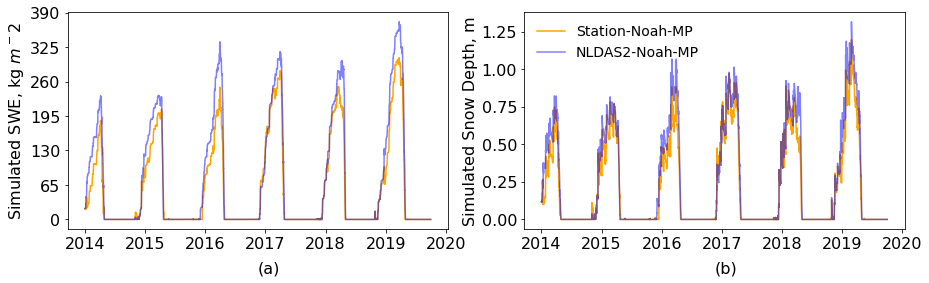

In [14]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(15,4))

Y1 = STATION_df.iloc[0:50376,:]["SNEQV"]
X1 = STATION_df.iloc[0:50376,:]["Time"]
ax1 = plt.subplot(1,2,1)
ax1.plot(X1, Y1, label = "Station-Noah-MP",color = 'orange',alpha=1)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(65))
text(0.5,-0.2,'(a)',transform=ax1.transAxes,fontsize="16")

Y2 = NLDAS_df.iloc[0:50376,:]["SNEQV"]
X2 = NLDAS_df.iloc[0:50376,:]["Time"]
ax1.plot(X2, Y2, label = "NLDAS2-Noah-MP",color='blue',alpha=0.5)
plt.ylabel("Simulated SWE, kg $m^-2$")

Y4 = STATION_df.iloc[0:50376,:]["SNOWH"]
X4 = STATION_df.iloc[0:50376,:]["Time"] 
ax2 = plt.subplot(1,2,2) 
ax2.plot(X4, Y4, label = "Station-Noah-MP",color = 'orange',alpha=1.0) 
text(0.5,-0.2,'(b)',transform=ax2.transAxes,fontsize="16")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.25)) 

Y5 = NLDAS_df.iloc[0:50376,:]["SNOWH"] 
X5 = NLDAS_df.iloc[0:50376,:]["Time"]
ax2.plot(X5, Y5, label = "NLDAS2-Noah-MP",color = 'blue',alpha=0.5)

ax2.xaxis.set_major_formatter(mpd.DateFormatter('%Y'))
plt.ylabel("Simulated Snow Depth, m") 
plt.legend(loc='upper left',ncol=1,fontsize=14,frameon=False)
fig.savefig('Figure3.jpeg',bbox_inches='tight',dpi=1600)

In [155]:
NLDAS_STATION_df = pd.merge(NLDAS_df, STATION_df, how='inner', left_on = 'Time', right_on = 'Time')
#SAFE_NLDAS_STATION_df = pd.merge(SAFE_NLDAS_STATION_df, SAFE_F, how='inner', left_on = 'Time', right_on = 'DATE_TIME_UTC')
NLDAS_STATION_df.drop('Unnamed: 0_x',axis=1,inplace=True)
NLDAS_STATION_df.drop('Unnamed: 0_y',axis=1,inplace=True)

NLDAS_STATION_df.rename(columns={'SNEQV_x':'SNEQV_NLD','SNOWH_x':'SNOWH_NLD','FSNO_x':'FSNO_NLD','ALBEDO_x':'ALBEDO_NLD','FSA_x':'FSA_NLD','FIRA_x':'FIRA_NLD','TRAD_x':'TRAD_NLD','LWUP_x':'LWUP_NLD','SWUP_x':'SWUP_NLD','ALBEDO_updated_x':'ALBEDO_updated_NLD','FSA_updated_x':'FSA_updated_NLD','SNEQV_y':'SNEQV_St','SNOWH_y':'SNOWH_St','FSNO_y':'FSNO_St','ALBEDO_y':'ALBEDO_St','FSA_y':'FSA_St','FIRA_y':'FIRA_St','FIRA_y':'FIRA_St','TRAD_y':'TRAD_St','LWUP_y':'LWUP_St','SWUP_y':'SWUP_St','ALBEDO_updated_y':'ALBEDO_updated_St','FSA_updated_y':'FSA_updated_St'},inplace=True)

NLDAS_STATION_df["SNEQV_DIFF_STATION_NLDAS"]= NLDAS_STATION_df["SNEQV_St"] - NLDAS_STATION_df["SNEQV_NLD"]
NLDAS_STATION_df["SNOWH_DIFF_STATION_NLDAS"]= NLDAS_STATION_df["SNOWH_St"] - NLDAS_STATION_df["SNOWH_NLD"]
NLDAS_STATION_df["FIRA_DIFF_STATION_NLDAS"]= NLDAS_STATION_df["FIRA_St"] - NLDAS_STATION_df["FIRA_NLD"]
NLDAS_STATION_df["FSA_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["FSA_updated_St"] - NLDAS_STATION_df["FSA_updated_NLD"]
NLDAS_STATION_df["TRAD_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["TRAD_St"] - NLDAS_STATION_df["TRAD_NLD"]
NLDAS_STATION_df["ALBEDO_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["ALBEDO_St"] - NLDAS_STATION_df["ALBEDO_NLD"]
NLDAS_STATION_df["ALBEDO_updated_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["ALBEDO_updated_St"] - NLDAS_STATION_df["ALBEDO_updated_NLD"]
NLDAS_STATION_df["SWUP_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["SWUP_St"] - NLDAS_STATION_df["SWUP_NLD"]
NLDAS_STATION_df["LWUP_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["LWUP_St"] - NLDAS_STATION_df["LWUP_NLD"]
NLDAS_STATION_df["FSNO_DIFF_STATION_NLDAS"] = NLDAS_STATION_df["FSNO_St"] - NLDAS_STATION_df["FSNO_NLD"]
NLDAS_STATION_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 52583
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Time                               52584 non-null  datetime64[ns]
 1   SNOWH_NLD                          52584 non-null  float64       
 2   SNEQV_NLD                          52584 non-null  float64       
 3   ALBEDO_NLD                         52570 non-null  float64       
 4   FSNO_NLD                           52583 non-null  float64       
 5   FSA_NLD                            52583 non-null  float64       
 6   FIRA_NLD                           52583 non-null  float64       
 7   TRAD_NLD                           52583 non-null  float64       
 8   LWUP_NLD                           52583 non-null  float64       
 9   SWUP_NLD                           52583 non-null  float64       
 10  ALBEDO_updated_NLD                

In [156]:
WY2014=NLDAS_STATION_df.loc[2289,'SNOWH_NLD']-NLDAS_STATION_df.loc[2287,'SNOWH_St']
WY2015=NLDAS_STATION_df.loc[10713,'SNOWH_NLD']-NLDAS_STATION_df.loc[11160,'SNOWH_St']
WY2016=NLDAS_STATION_df.loc[19646,'SNOWH_NLD']-NLDAS_STATION_df.loc[19646,'SNOWH_St']
WY2017=NLDAS_STATION_df.loc[28395,'SNOWH_NLD']-NLDAS_STATION_df.loc[28394,'SNOWH_St']
WY2018=NLDAS_STATION_df.loc[37389,'SNOWH_NLD']-NLDAS_STATION_df.loc[36836,'SNOWH_St']
WY2019=NLDAS_STATION_df.loc[45780,'SNOWH_NLD']-NLDAS_STATION_df.loc[45767,'SNOWH_St']

print('Mean BIAS for SNOWH at peak SWE all WYs (NLDAS2-Station) is: {}'.format((WY2014+WY2015+WY2016+WY2017+WY2018+WY2019)/6))

WY2014=NLDAS_STATION_df.loc[2289,'SNEQV_NLD']-NLDAS_STATION_df.loc[2287,'SNEQV_St']
WY2015=NLDAS_STATION_df.loc[10713,'SNEQV_NLD']-NLDAS_STATION_df.loc[11160,'SNEQV_St']
WY2016=NLDAS_STATION_df.loc[19646,'SNEQV_NLD']-NLDAS_STATION_df.loc[19646,'SNEQV_St']
WY2017=NLDAS_STATION_df.loc[28395,'SNEQV_NLD']-NLDAS_STATION_df.loc[28394,'SNEQV_St']
WY2018=NLDAS_STATION_df.loc[37389,'SNEQV_NLD']-NLDAS_STATION_df.loc[36836,'SNEQV_St']
WY2019=NLDAS_STATION_df.loc[45780,'SNEQV_NLD']-NLDAS_STATION_df.loc[45767,'SNEQV_St']

print('Mean BIAS for SNEQV at peak SWE all WYs (NLDAS2-Station) is: {}'.format((WY2014+WY2015+WY2016+WY2017+WY2018+WY2019)/6))

Mean BIAS for SNOWH at peak SWE all WYs (NLDAS2-Station) is: 0.11611666373331293
Mean BIAS for SNEQV at peak SWE all WYs (NLDAS2-Station) is: 51.85000077262519


In [157]:
Mean_BIAS_SNEQV_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['SNEQV_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNEQV in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNEQV_Acc))

Mean_BIAS_SNOWH_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['SNOWH_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNOWH in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNOWH_Acc))

Mean_BIAS_FIRA_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['FIRA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FIRA in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FIRA_Acc))

Mean_BIAS_FSA_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['FSA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSA in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSA_Acc))

Mean_BIAS_TRAD_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['TRAD_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for TRAD in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_TRAD_Acc))

Mean_BIAS_ALBEDO_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['ALBEDO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Acc))

Mean_BIAS_ALBEDO_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['ALBEDO_updated_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO updated in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Acc))

Mean_BIAS_LWUP_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['LWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for LWUP in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_LWUP_Acc))

Mean_BIAS_SWUP_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['SWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SWUP in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SWUP_Acc))

Mean_BIAS_FSNO_Acc = NLDAS_STATION_df.iloc[np.r_[0:2159,8016:10919,16775:19703,25559:28463,34319:37223,43080:45983]]['FSNO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSNO in Acc_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSNO_Acc))

print()

Mean_BIAS_SNEQV_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['SNEQV_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNEQV in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNEQV_Melt))

Mean_BIAS_SNOWH_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['SNOWH_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNOWH in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNOWH_Melt))

Mean_BIAS_FIRA_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['FIRA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FIRA in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FIRA_Melt))

Mean_BIAS_FSA_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['FSA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSA in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSA_Melt))

Mean_BIAS_TRAD_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['TRAD_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for TRAD_ in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_TRAD_Melt))

Mean_BIAS_ALBEDO_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['ALBEDO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Melt))

Mean_BIAS_ALBEDO_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['ALBEDO_updated_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO updated in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Melt))

Mean_BIAS_LWUP_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['LWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for LWUP in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_LWUP_Melt))

Mean_BIAS_SWUP_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['SWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SWUP in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_SWUP_Melt))

Mean_BIAS_FSNO_Melt = NLDAS_STATION_df.iloc[np.r_[2160:3623,10920:12383,19704:21167,28464:29927,37224:38687,45984:47447]]['FSNO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSNO in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSNO_Melt))

Mean BIAS for SNEQV in Acc_period all WYs (Station - NLDAS2) is: -32.9240469548901
Mean BIAS for SNOWH in Acc_period all WYs (Station - NLDAS2) is: -0.09131438605318297
Mean BIAS for FIRA in Acc_period all WYs (Station - NLDAS2) is: -5.430718643798264
Mean BIAS for FSA in Acc_period all WYs (Station - NLDAS2) is: -5.627591246063499
Mean BIAS for TRAD in Acc_period all WYs (Station - NLDAS2) is: 0.1960299430408344
Mean BIAS for ALBEDO in Acc_period all WYs (Station - NLDAS2) is: -0.0009486426347559134
Mean BIAS for ALBEDO updated in Acc_period all WYs (Station - NLDAS2) is: -0.005462275327010426
Mean BIAS for LWUP in Acc_period all WYs (Station - NLDAS2) is: 1.1149730715501274
Mean BIAS for SWUP in Acc_period all WYs (Station - NLDAS2) is: -18.990578748663875
Mean BIAS for FSNO in Acc_period all WYs (Station - NLDAS2) is: -0.01773850383654566

Mean BIAS for SNEQV in Melt_period all WYs (Station - NLDAS2) is: -25.169161915263906
Mean BIAS for SNOWH in Melt_period all WYs (Station - NLDAS

In [158]:
Mean_BIAS_SNEQV_Acc = NLDAS_STATION_df.loc[43080:45984,'SNEQV_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNEQV in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNEQV_Acc))

Mean_BIAS_SNOWH_Acc = NLDAS_STATION_df.loc[43080:45984,'SNOWH_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNOWH in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNOWH_Acc))

Mean_BIAS_FIRA_Acc = NLDAS_STATION_df.loc[43080:45984,'FIRA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FIRA in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_FIRA_Acc))

Mean_BIAS_FSA_Acc = NLDAS_STATION_df.loc[43080:45984,'FSA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSA in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSA_Acc))

Mean_BIAS_TRAD_Acc = NLDAS_STATION_df.loc[43080:45984,'TRAD_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for TRAD in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_TRAD_Acc))

Mean_BIAS_ALBEDO_Acc = NLDAS_STATION_df.loc[43080:45984,'ALBEDO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Acc))

Mean_BIAS_ALBEDO_Acc = NLDAS_STATION_df.loc[43080:45984,'ALBEDO_updated_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO updated in Acc_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Acc))

Mean_BIAS_LWUP_Acc = NLDAS_STATION_df.loc[43080:45984,'LWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for LWUP in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_LWUP_Acc))

Mean_BIAS_SWUP_Acc = NLDAS_STATION_df.loc[43080:45984,'SWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SWUP in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SWUP_Acc))

print()
Mean_BIAS_SNEQV_Acc = NLDAS_STATION_df.loc[45984:48169,'SNEQV_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNEQV in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNEQV_Acc))

Mean_BIAS_SNOWH_Acc = NLDAS_STATION_df.loc[45984:48169,'SNOWH_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SNOWH in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SNOWH_Acc))

Mean_BIAS_FIRA_Melt = NLDAS_STATION_df.loc[45984:48169,'FIRA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FIRA in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_FIRA_Melt))

Mean_BIAS_FSA_Melt = NLDAS_STATION_df.loc[45984:48169,'FSA_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for FSA in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_FSA_Melt))

Mean_BIAS_TRAD_Melt = NLDAS_STATION_df.loc[45984:48169,'TRAD_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for TRAD_ in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_TRAD_Melt))

Mean_BIAS_ALBEDO_Melt = NLDAS_STATION_df.loc[45984:48169,'ALBEDO_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Melt))

Mean_BIAS_ALBEDO_Melt = NLDAS_STATION_df.loc[45984:48169,'ALBEDO_updated_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for ALBEDO updated in Melt_period all WYs (Station - NLDAS2) is: {}'.format(Mean_BIAS_ALBEDO_Melt))

Mean_BIAS_LWUP_Melt = NLDAS_STATION_df.loc[45984:48169,'LWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for LWUP in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_LWUP_Melt))

Mean_BIAS_SWUP_Melt = NLDAS_STATION_df.loc[45984:48169,'SWUP_DIFF_STATION_NLDAS'].mean()
print('Mean BIAS for SWUP in Melt_period WY 2019 (Station - NLDAS2) is: {}'.format(Mean_BIAS_SWUP_Melt))

Mean BIAS for SNEQV in Acc_period WY 2019 (Station - NLDAS2) is: -46.92778038946774
Mean BIAS for SNOWH in Acc_period WY 2019 (Station - NLDAS2) is: -0.13661159723736885
Mean BIAS for FIRA in Acc_period WY 2019 (Station - NLDAS2) is: -5.853769450394914
Mean BIAS for FSA in Acc_period WY 2019 (Station - NLDAS2) is: -4.523752218872155
Mean BIAS for TRAD in Acc_period WY 2019 (Station - NLDAS2) is: 0.5830292685845432
Mean BIAS for ALBEDO in Acc_period WY 2019 (Station - NLDAS2) is: 0.010285714055810656
Mean BIAS for ALBEDO updated in Acc_period WY 2019 (Station - NLDAS2) is: 0.016120481567389995
Mean BIAS for LWUP in Melt_period WY 2019 (Station - NLDAS2) is: 2.605604765590355
Mean BIAS for SWUP in Melt_period WY 2019 (Station - NLDAS2) is: -17.979196218773108

Mean BIAS for SNEQV in Melt_period WY 2019 (Station - NLDAS2) is: -18.81505060058568
Mean BIAS for SNOWH in Melt_period WY 2019 (Station - NLDAS2) is: -0.04338751034035281
Mean BIAS for FIRA in Melt_period WY 2019 (Station - NLDAS2

In [159]:
Apr1SWE_DIFF_STATION_NLDAS_2019 = NLDAS_STATION_df.loc[46007,"SNEQV_St"] - NLDAS_STATION_df.loc[46007,"SNEQV_NLD"]
print('Bias for Apr1 SWE (Station - NLDAS) WY 2019 is: {}'.format(Apr1SWE_DIFF_STATION_NLDAS_2019))
Apr1SD_DIFF_STATION_NLDAS_2019 = NLDAS_STATION_df.loc[46007,"SNOWH_St"] - NLDAS_STATION_df.loc[46007,"SNOWH_NLD"]
print('Bias for Apr1 SD (Station - NLDAS) WY 2019 is: {}'.format(Apr1SD_DIFF_STATION_NLDAS_2019))

Bias for Apr1 SWE (Station - NLDAS) WY 2019 is: -76.3000011369586
Bias for Apr1 SD (Station - NLDAS) WY 2019 is: -0.1793999954679748


In [160]:
#Indices for 1st Apr SWE: 2183~2014; 10943~2015, 19727~2016, 28487~2017, 37247~2018, 46007~2019
Apr1SWE_DIFF_STATION_NLDAS_2014 = NLDAS_STATION_df.loc[2183,"SNEQV_St"] - NLDAS_STATION_df.loc[2183,"SNEQV_NLD"]
Apr1SWE_DIFF_STATION_NLDAS_2015 = NLDAS_STATION_df.loc[10943,"SNEQV_St"] - NLDAS_STATION_df.loc[10943,"SNEQV_NLD"]
Apr1SWE_DIFF_STATION_NLDAS_2016 = NLDAS_STATION_df.loc[19727,"SNEQV_St"] - NLDAS_STATION_df.loc[19727,"SNEQV_NLD"]
Apr1SWE_DIFF_STATION_NLDAS_2017 = NLDAS_STATION_df.loc[28487,"SNEQV_St"] - NLDAS_STATION_df.loc[28487,"SNEQV_NLD"]
Apr1SWE_DIFF_STATION_NLDAS_2018 = NLDAS_STATION_df.loc[37247,"SNEQV_St"] - NLDAS_STATION_df.loc[37247,"SNEQV_NLD"]
Apr1SWE_DIFF_STATION_NLDAS_2019 = NLDAS_STATION_df.loc[46007,"SNEQV_St"] - NLDAS_STATION_df.loc[46007,"SNEQV_NLD"]

Apr1SD_DIFF_STATION_NLDAS_2014 = NLDAS_STATION_df.loc[2183,"SNOWH_St"] - NLDAS_STATION_df.loc[2183,"SNOWH_NLD"]
Apr1SD_DIFF_STATION_NLDAS_2015 = NLDAS_STATION_df.loc[10943,"SNOWH_St"] - NLDAS_STATION_df.loc[10943,"SNOWH_NLD"]
Apr1SD_DIFF_STATION_NLDAS_2016 = NLDAS_STATION_df.loc[19727,"SNOWH_St"] - NLDAS_STATION_df.loc[19727,"SNOWH_NLD"]
Apr1SD_DIFF_STATION_NLDAS_2017 = NLDAS_STATION_df.loc[28487,"SNOWH_St"] - NLDAS_STATION_df.loc[28487,"SNOWH_NLD"]
Apr1SD_DIFF_STATION_NLDAS_2018 = NLDAS_STATION_df.loc[37247,"SNOWH_St"] - NLDAS_STATION_df.loc[37247,"SNOWH_NLD"]
Apr1SD_DIFF_STATION_NLDAS_2019 = NLDAS_STATION_df.loc[46007,"SNOWH_St"] - NLDAS_STATION_df.loc[46007,"SNOWH_NLD"]

a = np.mean([Apr1SWE_DIFF_STATION_NLDAS_2014,Apr1SWE_DIFF_STATION_NLDAS_2015,Apr1SWE_DIFF_STATION_NLDAS_2016,Apr1SWE_DIFF_STATION_NLDAS_2017,Apr1SWE_DIFF_STATION_NLDAS_2018,Apr1SWE_DIFF_STATION_NLDAS_2019])
print('Mean Bias for Apr1 SWE (Station - NLDAS) is: {}'.format(a))

b = np.mean([Apr1SD_DIFF_STATION_NLDAS_2014,Apr1SD_DIFF_STATION_NLDAS_2015,Apr1SD_DIFF_STATION_NLDAS_2016,Apr1SD_DIFF_STATION_NLDAS_2017,Apr1SD_DIFF_STATION_NLDAS_2018,Apr1SD_DIFF_STATION_NLDAS_2019])
print('Mean Bias for Apr1 SD (Station - NLDAS) is: {}'.format(b))

Mean Bias for Apr1 SWE (Station - NLDAS) is: -57.033334183196224
Mean Bias for Apr1 SD (Station - NLDAS) is: -0.1288999967437121


In [161]:
from scipy import stats as st

In [21]:
#Paired t-test by water year for shortwave radiation
a = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:6552,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) #2014 WY
b = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[6552:15312,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) # 2015 WY
c = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[15312:24096,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) # 2016 WY
d = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[24096:32856,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) # 2017 WY
e = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[32856:41616,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) # 2018 WY
f = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[41616:50376,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0) # 2019 WY

print("WY2014 FIRA: STATION vs NLDAS is: {}".format(a))
print("WY2015 FIRA: STATION vs NLDAS is: {}".format(b))
print("WY2016 FIRA: STATION vs NLDAS is: {}".format(c))
print("WY2017 FIRA: STATION vs NLDAS is: {}".format(d))
print("WY2018 FIRA: STATION vs NLDAS is: {}".format(e))
print("WY2019 FIRA: STATION vs NLDAS is: {}".format(f))
print("\n")

#Paired t-test by accumulation and melt period in each water year for shortwave radiation
g = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:2160,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2014 water year accumulation
h = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[2160:3624,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2014 water year melt
i = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[8016:10920,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2014-2015 water year accumulation
j = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[10920:12384,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2015 water year melt
k = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[16776:19704,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2015-2016 water year accumulation
l = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[19704:21168,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2016 water year melt
m = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[25560:28464,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2016-2017 water year accumulation
n = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[28464:29928,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2017 water year melt
o = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[34320:37224,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2017-2018 water year accumulation
p = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[37224:38688,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2018 water year melt
q = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[43080:45984,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2018-2019 water year accumulation
r = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[45984:47448,:].dropna()['FIRA_DIFF_STATION_NLDAS'],0)#2019 water year melt

print("WY2014 Accumulation FIRA: STATION vs NLDAS is: {}".format(g))
print("WY2014 Melt FIRA: STATION vs NLDAS is: {}".format(h))
print("WY2015 Accumulation FIRA: STATION vs NLDAS is: {}".format(i))
print("WY2015 Melt FIRA: STATION vs NLDAS is: {}".format(j))
print("WY2016 Accumulation FIRA: STATION vs NLDAS is: {}".format(k))
print("WY2016 Melt  FIRA: STATION vs NLDAS is: {}".format(l))
print("WY2017 Accumulation  FIRA: STATION vs NLDAS is: {}".format(m))
print("WY2017 Melt  FIRA: STATION vs NLDAS is: {}".format(n))
print("WY2018 Accumulation  SW: STATION vs NLDAS is: {}".format(o))
print("WY2018 Melt  FIRA: STATION vs NLDAS is: {}".format(p))
print("WY2019 Accumulation  SW: STATION vs NLDAS is: {}".format(q))
print("WY2019 Melt  FIRA: STATION vs NLDAS is: {}".format(r))

WY2014 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-25.6709212335914, pvalue=1.0733212912347336e-135)
WY2015 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-35.59658531713778, pvalue=1.755447353632367e-256)
WY2016 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-23.406400593259406, pvalue=1.4726077329031535e-115)
WY2017 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-21.701232302654958, pvalue=4.912584458009692e-99)
WY2018 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-31.156124713020183, pvalue=3.0617305914242167e-198)
WY2019 FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-28.643272531503353, pvalue=9.262899935190344e-172)


WY2014 Accumulation FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-9.457912279478807, pvalue=8.026096334138779e-21)
WY2014 Melt FIRA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-17.11096293085068, pvalue=1.1788344055669743e-58)
WY2015 Accumulation FIRA: STATION vs NLDAS is: Ttest_1sampResult(statist

In [22]:
#Paired t-test by water year for longwave radiation
a = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:6552,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) #2014 WY
b = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[6552:15312,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) # 2015 WY
c = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[15312:24096,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) # 2016 WY
d = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[24096:32856,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) # 2017 WY
e = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[32856:41616,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) # 2018 WY
f = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[41616:50376,:].dropna()['FSA_DIFF_STATION_NLDAS'],0) # 2019 WY

print("WY2014 FSA: STATION vs NLDAS is: {}".format(a))
print("WY2015 FSA: STATION vs NLDAS is: {}".format(b))
print("WY2016 FSA: STATION vs NLDAS is: {}".format(c))
print("WY2017 FSA: STATION vs NLDAS is: {}".format(d))
print("WY2018 FSA: STATION vs NLDAS is: {}".format(e))
print("WY2019 FSA: STATION vs NLDAS is: {}".format(f))
print("\n")

#Paired t-test by accumulation and melt period in each water year for long wave radiation
g = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:2160,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2014 water year accumulation
h = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[2160:3624,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2014 water year melt
i = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[8016:10920,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2014-2015 water year accumulation
j = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[10920:12384,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2015 water year melt
k = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[16776:19704,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2015-2016 water year accumulation
l = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[19704:21168,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2016 water year melt
m = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[25560:28464,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2016-2017 water year accumulation
n = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[28464:29928,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2017 water year melt
o = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[34320:37224,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2017-2018 water year accumulation
p = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[37224:38688,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2018 water year melt
q = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[43080:45984,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2018-2019 water year accumulation
r = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[45984:47448,:].dropna()['FSA_DIFF_STATION_NLDAS'],0)#2019 water year melt

print("WY2014 Accumulation FSA: STATION vs NLDAS is: {}".format(g))
print("WY2014 Melt FSA: STATION vs NLDAS is: {}".format(h))
print("WY2015 Accumulation FSA: STATION vs NLDAS is: {}".format(i))
print("WY2015 Melt FSA: STATION vs NLDAS is: {}".format(j))
print("WY2016 Accumulation FSA: STATION vs NLDAS is: {}".format(k))
print("WY2016 Melt  FSA: STATION vs NLDAS is: {}".format(l))
print("WY2017 Accumulation  FSA: STATION vs NLDAS is: {}".format(m))
print("WY2017 Melt  FSA: STATION vs NLDAS is: {}".format(n))
print("WY2018 Accumulation  FSA: STATION vs NLDAS is: {}".format(o))
print("WY2018 Melt  FSA: STATION vs NLDAS is: {}".format(p))
print("WY2019 Accumulation  FSA: STATION vs NLDAS is: {}".format(q))
print("WY2019 Melt  FSA: STATION vs NLDAS is: {}".format(r))

WY2014 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-15.289337610996448, pvalue=1.76815346509722e-51)
WY2015 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-19.48584731631718, pvalue=1.5860609481338222e-82)
WY2016 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-12.655581449379694, pvalue=3.3344510012339476e-36)
WY2017 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-17.4848505244485, pvalue=4.0276057191999073e-66)
WY2018 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-14.37114918336499, pvalue=4.228147874675587e-46)
WY2019 FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-14.569192659379121, pvalue=1.8138166614291516e-47)


WY2014 Accumulation FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-14.75852821293124, pvalue=5.352150704023309e-47)
WY2014 Melt FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-11.638333989165918, pvalue=1.1221200049562606e-29)
WY2015 Accumulation FSA: STATION vs NLDAS is: Ttest_1sampResult(statistic=-13.7529536

In [23]:
#Paired t-test by water year for shortwave radiation
a = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:6552,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) #2014 WY
b = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[6552:15312,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) # 2015 WY
c = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[15312:24096,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) # 2016 WY
d = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[24096:32856,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) # 2017 WY
e = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[32856:41616,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) # 2018 WY
f = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[41616:50376,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0) # 2019 WY

print("WY2014 TRAD: STATION vs NLDAS is: {}".format(a))
print("WY2015 TRAD: STATION vs NLDAS is: {}".format(b))
print("WY2016 TRAD: STATION vs NLDAS is: {}".format(c))
print("WY2017 TRAD: STATION vs NLDAS is: {}".format(d))
print("WY2018 TRAD: STATION vs NLDAS is: {}".format(e))
print("WY2019 TRAD: STATION vs NLDAS is: {}".format(f))
print("\n")

#Paired t-test by accumulation and melt period in each water year for shortwave radiation
g = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:2160,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2014 water year accumulation
h = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[2160:3624,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2014 water year melt
i = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[8016:10920,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2014-2015 water year accumulation
j = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[10920:12384,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2015 water year melt
k = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[16776:19704,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2015-2016 water year accumulation
l = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[19704:21168,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2016 water year melt
m = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[25560:28464,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2016-2017 water year accumulation
n = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[28464:29928,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2017 water year melt
o = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[34320:37224,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2017-2018 water year accumulation
p = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[37224:38688,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2018 water year melt
q = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[43080:45984,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2018-2019 water year accumulation
r = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[45984:47448,:].dropna()['TRAD_DIFF_STATION_NLDAS'],0)#2019 water year melt

print("WY2014 Accumulation TRAD: STATION vs NLDAS is: {}".format(g))
print("WY2014 Melt TRAD: STATION vs NLDAS is: {}".format(h))
print("WY2015 Accumulation TRAD: STATION vs NLDAS is: {}".format(i))
print("WY2015 Melt TRAD: STATION vs NLDAS is: {}".format(j))
print("WY2016 Accumulation TRAD: STATION vs NLDAS is: {}".format(k))
print("WY2016 Melt  TRAD: STATION vs NLDAS is: {}".format(l))
print("WY2017 Accumulation  TRAD: STATION vs NLDAS is: {}".format(m))
print("WY2017 Melt  TRAD: STATION vs NLDAS is: {}".format(n))
print("WY2018 Accumulation  TRAD: STATION vs NLDAS is: {}".format(o))
print("WY2018 Melt  TRAD: STATION vs NLDAS is: {}".format(p))
print("WY2019 Accumulation  TRAD: STATION vs NLDAS is: {}".format(q))
print("WY2019 Melt  TRAD: STATION vs NLDAS is: {}".format(r))

WY2014 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=-8.308228864230822, pvalue=1.2740420726453667e-16)
WY2015 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=-17.66237859691696, pvalue=1.9896574278383158e-68)
WY2016 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=1.5411319470320528, pvalue=0.12334245684653143)
WY2017 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=2.3665020178047875, pvalue=0.01800246855141909)
WY2018 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=7.478277314679169, pvalue=8.563883746645728e-14)
WY2019 TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=3.1101150910675224, pvalue=0.001876802140460657)


WY2014 Accumulation TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=-5.559895154681187, pvalue=3.039549182112255e-08)
WY2014 Melt TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=-5.555208687471393, pvalue=3.442322185246994e-08)
WY2015 Accumulation TRAD: STATION vs NLDAS is: Ttest_1sampResult(statistic=-0.5167999560

In [24]:
#Paired t-test by water year for shortwave radiation
a = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:6552,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) #2014 WY
b = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[6552:15312,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) # 2015 WY
c = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[15312:24096,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) # 2016 WY
d = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[24096:32856,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) # 2017 WY
e = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[32856:41616,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) # 2018 WY
f = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[41616:50376,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0) # 2019 WY

print("WY2014 ALBEDO: STATION vs NLDAS is: {}".format(a))
print("WY2015 ALBEDO: STATION vs NLDAS is: {}".format(b))
print("WY2016 ALBEDO: STATION vs NLDAS is: {}".format(c))
print("WY2017 ALBEDO: STATION vs NLDAS is: {}".format(d))
print("WY2018 ALBEDO: STATION vs NLDAS is: {}".format(e))
print("WY2019 ALBEDO: STATION vs NLDAS is: {}".format(f))
print("\n")

#Paired t-test by accumulation and melt period in each water year for shortwave radiation
g = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[0:2160,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2014 water year accumulation
h = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[2160:3624,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2014 water year melt
i = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[8016:10920,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2014-2015 water year accumulation
j = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[10920:12384,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2015 water year melt
k = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[16776:19704,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2015-2016 water year accumulation
l = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[19704:21168,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2016 water year melt
m = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[25560:28464,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2016-2017 water year accumulation
n = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[28464:29928,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2017 water year melt
o = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[34320:37224,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2017-2018 water year accumulation
p = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[37224:38688,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2018 water year melt
q = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[43080:45984,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2018-2019 water year accumulation
r = st.stats.ttest_1samp(NLDAS_STATION_df.iloc[45984:47448,:].dropna()['ALBEDO_DIFF_STATION_NLDAS'],0)#2019 water year melt

print("WY2014 Accumulation ALBEDO: STATION vs NLDAS is: {}".format(g))
print("WY2014 Melt ALBEDO: STATION vs NLDAS is: {}".format(h))
print("WY2015 Accumulation ALBEDO: STATION vs NLDAS is: {}".format(i))
print("WY2015 Melt ALBEDO: STATION vs NLDAS is: {}".format(j))
print("WY2016 Accumulation ALBEDO: STATION vs NLDAS is: {}".format(k))
print("WY2016 Melt  ALBEDO: STATION vs NLDAS is: {}".format(l))
print("WY2017 Accumulation  ALBEDO: STATION vs NLDAS is: {}".format(m))
print("WY2017 Melt  ALBEDO: STATION vs NLDAS is: {}".format(n))
print("WY2018 Accumulation  ALBEDO: STATION vs NLDAS is: {}".format(o))
print("WY2018 Melt  ALBEDO: STATION vs NLDAS is: {}".format(p))
print("WY2019 Accumulation  ALBEDO: STATION vs NLDAS is: {}".format(q))
print("WY2019 Melt  ALBEDO: STATION vs NLDAS is: {}".format(r))

WY2014 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=8.810295896980826, pvalue=1.756147301940787e-18)
WY2015 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=20.536042284302255, pvalue=3.2884118119123274e-91)
WY2016 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=-13.92466628980108, pvalue=2.4417643450522774e-43)
WY2017 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=25.324619131146413, pvalue=9.501544509067591e-132)
WY2018 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=-5.542462592536781, pvalue=3.1041621841375034e-08)
WY2019 ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=6.136114051031797, pvalue=8.864025868951587e-10)


WY2014 Accumulation ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=30.351493550635542, pvalue=2.3514106455847295e-168)
WY2014 Melt ALBEDO: STATION vs NLDAS is: Ttest_1sampResult(statistic=-0.4407930173424418, pvalue=0.6594456252812311)
WY2015 Accumulation ALBEDO: STATION vs NLDAS is: Ttest_1sampResult

In [162]:
column_names=["Time","SAFE_SR01Dn_Avg","Station-Noah-MP_SWUP"]
df_SAFE_Station_RefSW = pd.DataFrame(columns = column_names)
df_SAFE_Station_RefSW["Time"] = STATION_df["Time"]
df_SAFE_Station_RefSW["SAFE_SR01Dn_Avg"] = SAFE_F["SR01Dn_Avg"]
df_SAFE_Station_RefSW["Station-Noah-MP_SWUP"] = STATION_df["SWUP"]
df_SAFE_Station_RefSW_drop=df_SAFE_Station_RefSW.dropna()
df_SAFE_Station_RefSW_drop.info()

column_names=["Time","SAFE_SR01Dn_Avg","Station-Noah-MP_SWUP"]
df_SAFE_Station_RefSW = pd.DataFrame(columns = column_names)
df_SAFE_Station_RefSW["Time"] = STATION_df["Time"]
df_SAFE_Station_RefSW["SAFE_SR01Dn_Avg"] = SAFE_F["SR01Dn_Avg"]
df_SAFE_Station_RefSW["Station-Noah-MP_SWUP"] = STATION_df["SWUP"]
df_SAFE_Station_RefSW_drop=df_SAFE_Station_RefSW.dropna()
df_SAFE_Station_RefSW_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37823 entries, 1 to 52583
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time                  37823 non-null  datetime64[ns]
 1   SAFE_SR01Dn_Avg       37823 non-null  float64       
 2   Station-Noah-MP_SWUP  37823 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37823 entries, 1 to 52583
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time                  37823 non-null  datetime64[ns]
 1   SAFE_SR01Dn_Avg       37823 non-null  float64       
 2   Station-Noah-MP_SWUP  37823 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [26]:
r, _ = pearsonr(df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"],df_SAFE_Station_RefSW_drop["Station-Noah-MP_SWUP"])

a = (df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"]-df_SAFE_Station_RefSW_drop["Station-Noah-MP_SWUP"]).sum()
b = df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"].sum()
PBIAS_Observed_Station_RefSW = 100*(a/b)
print('PBIAS between Observed and Station-Noah-MP for Reflected Shortwave Radiation is: {}'.format(PBIAS_Observed_Station_RefSW))

rmse = np.sqrt(mean_squared_error(df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"], df_SAFE_Station_RefSW_drop["Station-Noah-MP_SWUP"]))
print('Root mean square error is: {}'.format(rmse))

rmse_check = np.sqrt(((df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"] - df_SAFE_Station_RefSW_drop["Station-Noah-MP_SWUP"])**2).sum() / df_SAFE_Station_RefSW_drop["SAFE_SR01Dn_Avg"].count())
print('rmse_check is {}'.format(rmse_check))
print('Pearsons correlation: %.3f' % r)

PBIAS between Observed and Station-Noah-MP for Reflected Shortwave Radiation is: 9.564089861060317
Root mean square error is: 36.09606488641998
rmse_check is 36.09606488641998
Pearsons correlation: 0.938


In [228]:
rainsnow_dec

,Date,SAFE_CumSnow,SAFE_CumSnow_zeroed,NLDAS_CumSnow,NLDAS_CumSnow_zeroed,SAFE_CumRain,SAFE_CumRain_zeroed,NLDAS_CumRain,NLDAS_CumRain_zeroed
43512,2018-12-19 00:00:00,40.873976,0.000000,36.776908,4.058497e-07,0.816024,9.769963e-15,0.000000,0.000000
43513,2018-12-19 01:00:00,40.873976,0.000000,36.776908,4.058497e-07,0.816024,9.769963e-15,0.000000,0.000000
43514,2018-12-19 02:00:00,40.873976,0.000000,36.776908,4.058497e-07,0.816024,9.769963e-15,0.000000,0.000000
43515,2018-12-19 03:00:00,40.873976,0.000000,36.776908,4.058497e-07,0.816024,9.769963e-15,0.000000,0.000000
43516,2018-12-19 04:00:00,40.898976,0.025000,36.776908,4.058497e-07,0.816024,9.769963e-15,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
43675,2018-12-25 19:00:00,45.268392,4.394416,68.668469,3.189156e+01,37.973608,3.715758e+01,11.675501,11.675501
43676,2018-12-25 20:00:00,45.268392,4.394416,68.668469,3.189156e+01,37.973608,3.715758e+01,11.675501,11.675501
43677,2018-12-25 21:00:00,45.268392,4.394416,68.668469,3.189156e+01,37.973608,3.715758e+01,11.675501,11.675501
43678,2018-12-25 22:00:00,45.268392,4.394416,68.668469,3.189156e+01,37.973608,3.715758e+01,11.675501,11.675501


In [227]:
rainsnow_nov

,Date,SAFE_CumSnow,SAFE_CumSnow_zeroed,NLDAS_CumSnow,NLDAS_CumSnow_zeroed,SAFE_CumRain,SAFE_CumRain_zeroed,NLDAS_CumRain,NLDAS_CumRain_zeroed
42912,2018-11-24 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42913,2018-11-24 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42914,2018-11-24 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42915,2018-11-24 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42916,2018-11-24 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
43075,2018-11-30 19:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43076,2018-11-30 20:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43077,2018-11-30 21:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43078,2018-11-30 22:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615


In [8]:
column_name = ["Date","SAFE_CumSnow","SAFE_CumSnow_zeroed","NLDAS_CumSnow","NLDAS_CumSnow_zeroed","SAFE_CumRain","SAFE_CumRain_zeroed","NLDAS_CumRain","NLDAS_CumRain_zeroed"]
rainsnow_nov=pd.DataFrame(columns = column_name)
rainsnow_nov["Date"] = rainsnow.loc[42912:43079,"Date"]

rainsnow_nov["SAFE_CumSnow"] = rainsnow.loc[42912:43079,"SAFE_CumSnow"]*1000
rainsnow_nov["NLDAS_CumSnow"] = rainsnow.loc[42912:43079,"NLDAS_CumSnow"]*1000
rainsnow_nov["SAFE_CumSnow"] = pd.to_numeric(rainsnow_nov["SAFE_CumSnow"],errors='coerce')
rainsnow_nov["NLDAS_CumSnow"]  =pd.to_numeric(rainsnow_nov["NLDAS_CumSnow"],errors='coerce')

rainsnow_nov["SAFE_CumRain"] = rainsnow.loc[42912:43079,"SAFE_CumRain"]*1000
rainsnow_nov["NLDAS_CumRain"] = rainsnow.loc[42912:43079,"NLDAS_CumRain"]*1000
rainsnow_nov["SAFE_CumRain"] = pd.to_numeric(rainsnow_nov["SAFE_CumRain"],errors='coerce')
rainsnow_nov["NLDAS_CumRain"] = pd.to_numeric(rainsnow_nov["NLDAS_CumRain"],errors='coerce')

rainsnow_nov["SAFE_CumSnow_zeroed"]=rainsnow_nov["SAFE_CumSnow"]-0*1000 #0.0733621*1000
rainsnow_nov["NLDAS_CumSnow_zeroed"]=rainsnow_nov["NLDAS_CumSnow"]-0*1000 #0.0644555*1000
rainsnow_nov['SAFE_CumSnow_zeroed']=rainsnow_nov['SAFE_CumSnow_zeroed'].mask(rainsnow_nov['SAFE_CumSnow_zeroed'].lt(0),0)
rainsnow_nov['NLDAS_CumSnow_zeroed']=rainsnow_nov['NLDAS_CumSnow_zeroed'].mask(rainsnow_nov['NLDAS_CumSnow_zeroed'].lt(0),0)

rainsnow_nov["SAFE_CumRain_zeroed"]=rainsnow_nov["SAFE_CumRain"]-0 #0.144114*1000
rainsnow_nov["NLDAS_CumRain_zeroed"]=rainsnow_nov["NLDAS_CumRain"]-0 #0.14208021*1000
rainsnow_nov['SAFE_CumRain_zeroed']=rainsnow_nov['SAFE_CumRain_zeroed'].mask(rainsnow_nov['SAFE_CumRain_zeroed'].lt(0),0)
rainsnow_nov['NLDAS_CumRain_zeroed']=rainsnow_nov['NLDAS_CumRain_zeroed'].mask(rainsnow_nov['NLDAS_CumRain_zeroed'].lt(0.000003),0)

rainsnow_nov.info()

column_name = ["Date","SAFE_CumSnow","SAFE_CumSnow_zeroed","NLDAS_CumSnow","NLDAS_CumSnow_zeroed","SAFE_CumRain","SAFE_CumRain_zeroed","NLDAS_CumRain","NLDAS_CumRain_zeroed"]
rainsnow_dec=pd.DataFrame(columns = column_name)
rainsnow_dec["Date"] = rainsnow.loc[43512:43679,"Date"]

rainsnow_dec["SAFE_CumSnow"] = rainsnow.loc[43512:43679,"SAFE_CumSnow"]*1000
rainsnow_dec["NLDAS_CumSnow"] = rainsnow.loc[43512:43679,"NLDAS_CumSnow"]*1000
rainsnow_dec["SAFE_CumSnow"] = pd.to_numeric(rainsnow_dec["SAFE_CumSnow"],errors='coerce')
rainsnow_dec["NLDAS_CumSnow"]  =pd.to_numeric(rainsnow_dec["NLDAS_CumSnow"],errors='coerce')

rainsnow_dec["SAFE_CumRain"] = rainsnow.loc[43512:43679,"SAFE_CumRain"]*1000
rainsnow_dec["NLDAS_CumRain"] = rainsnow.loc[43512:43679,"NLDAS_CumRain"]*1000
rainsnow_dec["SAFE_CumRain"] = pd.to_numeric(rainsnow_dec["SAFE_CumRain"],errors='coerce')
rainsnow_dec["NLDAS_CumRain"] = pd.to_numeric(rainsnow_dec["NLDAS_CumRain"],errors='coerce')

rainsnow_dec["SAFE_CumSnow_zeroed"]=rainsnow_dec["SAFE_CumSnow"]-40.873976 #0.127150*1000 # to sart from zero for this period in the figure
rainsnow_dec["NLDAS_CumSnow_zeroed"]=rainsnow_dec["NLDAS_CumSnow"]-36.776908 #0.117502*1000
rainsnow_dec["SAFE_CumSnow_zeroed"]=rainsnow_dec["SAFE_CumSnow_zeroed"].mask(rainsnow_dec['SAFE_CumSnow_zeroed'].lt(0),0)
rainsnow_dec['NLDAS_CumSnow_zeroed']=rainsnow_dec['NLDAS_CumSnow_zeroed'].mask(rainsnow_dec['NLDAS_CumSnow_zeroed'].lt(0),0)

rainsnow_dec["SAFE_CumRain_zeroed"]=rainsnow_dec["SAFE_CumRain"]-0.816024 #0.147347*1000
rainsnow_dec["NLDAS_CumRain_zeroed"]=rainsnow_dec["NLDAS_CumRain"]-0 #0.144213*1000
rainsnow_dec['SAFE_CumRain_zeroed']=rainsnow_dec['SAFE_CumRain_zeroed'].mask(rainsnow_dec['SAFE_CumRain_zeroed'].lt(0),0)
rainsnow_dec['NLDAS_CumRain_zeroed']=rainsnow_dec['NLDAS_CumRain_zeroed'].mask(rainsnow_dec['NLDAS_CumRain_zeroed'].lt(0),0)

rainsnow_dec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 42912 to 43079
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  168 non-null    datetime64[ns]
 1   SAFE_CumSnow          168 non-null    float64       
 2   SAFE_CumSnow_zeroed   168 non-null    float64       
 3   NLDAS_CumSnow         168 non-null    float64       
 4   NLDAS_CumSnow_zeroed  168 non-null    float64       
 5   SAFE_CumRain          168 non-null    float64       
 6   SAFE_CumRain_zeroed   168 non-null    float64       
 7   NLDAS_CumRain         168 non-null    float64       
 8   NLDAS_CumRain_zeroed  168 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 11.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 43512 to 43679
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------             

In [216]:
rainsnow_nov

,Date,SAFE_CumSnow,SAFE_CumSnow_zeroed,NLDAS_CumSnow,NLDAS_CumSnow_zeroed,SAFE_CumRain,SAFE_CumRain_zeroed,NLDAS_CumRain,NLDAS_CumRain_zeroed
42912,2018-11-24 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42913,2018-11-24 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42914,2018-11-24 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42915,2018-11-24 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42916,2018-11-24 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
43075,2018-11-30 19:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43076,2018-11-30 20:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43077,2018-11-30 21:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615
43078,2018-11-30 22:00:00,12.913536,12.913536,16.269216,16.269216,2.418464,2.418464,2.132615,2.132615


In [148]:
    
Sum_NLDAS_CumSnow_1Apr = rainsnow.iloc[np.r_[2160,10920,19704,28464,37224,45984]]['NLDAS_CumSnow'].sum()
print('Sum of Cum Snow all WY NLDAS 1 Apr is: {}'.format(Sum_NLDAS_CumSnow_Acc))

Sum_NLDAS_CumRain_1Apr = rainsnow.iloc[np.r_[2160,10920,19704,28464,37224,45984]]['NLDAS_CumRain'].sum()
print('Sum of Cum Rain all WY NLDAS 1 Apr is: {}'.format(Sum_NLDAS_CumRain_Acc))

Sum_SAFE_CumSnow_1Apr = rainsnow.iloc[np.r_[2160,10920,19704,28464,37224,45984]]['SAFE_CumSnow'].sum()
print('Sum of Cum Snow all WY SAFE 1 Apr is: {}'.format(Sum_SAFE_CumSnow_Acc))

Sum_SAFE_CumRain_1Apr = rainsnow.iloc[np.r_[2160,10920,19704,28464,37224,45984]]['SAFE_CumRain'].sum()
print('Sum of Cum Rain all WY SAFE 1 Apr is: {}'.format(Sum_SAFE_CumRain_Acc))

print('% Cum_Snow over Cum_PPT all WY NLDAS 1 Apr is: {}'.format(100*Sum_NLDAS_CumSnow_1Apr/2.8094296729158637)) #2.8094296729158637 #Sum of Cum precip all WY NLDAS 1 Apr is: from  NLDAS_Forcings_new-Copy5
print('% Cum_Rain over Cum_PPT all WY NLDAS 1 Apr is: {}'.format(100*Sum_NLDAS_CumRain_1Apr/2.8094296729158637))

print('% Cum_Snow over Cum_PPT all WY SAFE 1 Apr is: {}'.format(100*Sum_SAFE_CumSnow_1Apr/2.8603779999999794)) ##Sum of Cum precip all WY SAFE 1 Apr is:
print('% Cum_Rain over Cum_PPT all WY SAFE 1 Apr is: {}'.format(100*Sum_SAFE_CumRain_1Apr/2.8603779999999794))

NameError: name 'Sum_NLDAS_CumSnow_Acc' is not defined

In [208]:
rainsnow_dec

,Date,SAFE_CumSnow,SAFE_CumSnow_zeroed,NLDAS_CumSnow,NLDAS_CumSnow_zeroed,SAFE_CumRain,SAFE_CumRain_zeroed,NLDAS_CumRain,NLDAS_CumRain_zeroed
43512,2018-12-19 00:00:00,40.873976,0.0,36.776908,0.0,0.816024,0.0,0.000000,0.0
43513,2018-12-19 01:00:00,40.873976,0.0,36.776908,0.0,0.816024,0.0,0.000000,0.0
43514,2018-12-19 02:00:00,40.873976,0.0,36.776908,0.0,0.816024,0.0,0.000000,0.0
43515,2018-12-19 03:00:00,40.873976,0.0,36.776908,0.0,0.816024,0.0,0.000000,0.0
43516,2018-12-19 04:00:00,40.898976,0.0,36.776908,0.0,0.816024,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
43675,2018-12-25 19:00:00,45.268392,0.0,68.668469,0.0,37.973608,0.0,11.675501,0.0
43676,2018-12-25 20:00:00,45.268392,0.0,68.668469,0.0,37.973608,0.0,11.675501,0.0
43677,2018-12-25 21:00:00,45.268392,0.0,68.668469,0.0,37.973608,0.0,11.675501,0.0
43678,2018-12-25 22:00:00,45.268392,0.0,68.668469,0.0,37.973608,0.0,11.675501,0.0


In [9]:
NLDAS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      52584 non-null  int64         
 1   Time            52584 non-null  datetime64[ns]
 2   SNOWH           52584 non-null  float64       
 3   SNEQV           52584 non-null  float64       
 4   ALBEDO          52570 non-null  float64       
 5   FSNO            52583 non-null  float64       
 6   FSA             52583 non-null  float64       
 7   FIRA            52583 non-null  float64       
 8   TRAD            52583 non-null  float64       
 9   LWUP            52583 non-null  float64       
 10  SWUP            52583 non-null  float64       
 11  ALBEDO_updated  52583 non-null  float64       
 12  FSA_updated     52584 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 5.2 MB


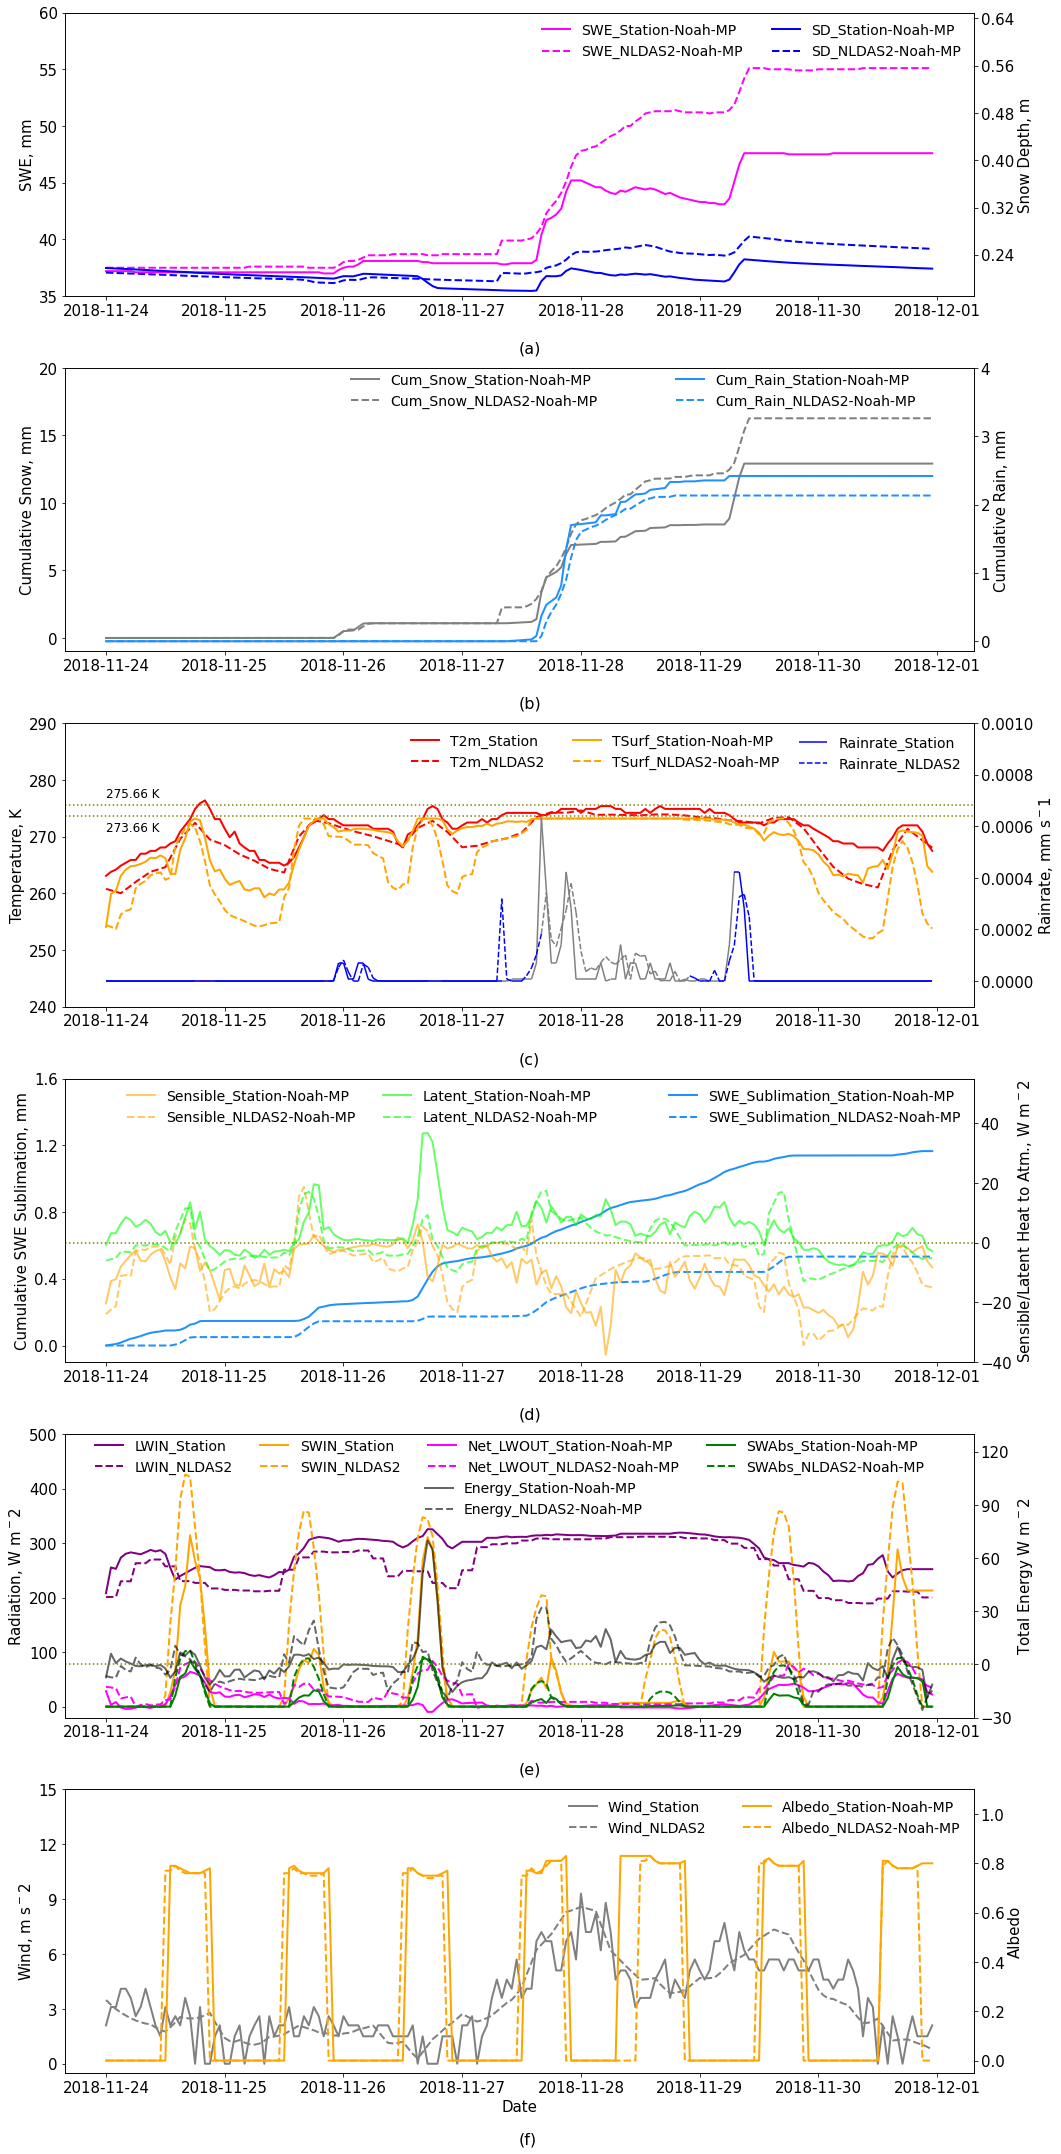

In [27]:
fig = plt.figure(figsize=(15,30))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots()
matplotlib.rcParams.update({'font.size': 15})

ax0 = plt.subplot(6,1,1)
ax0.plot("Time","SNEQV",data=STATION_df[42912:43080], marker='', color='magenta', linewidth=2);
ax0.plot("Time","SNEQV",data=NLDAS_df[42912:43080], marker='', color='magenta', linewidth=2,linestyle='dashed');
ax0.set_ylabel('SWE, mm')
#ax0.set_xlabel('Date')
ax0.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax0.set_ylim(35,60)
ax0.legend(['SWE_Station-Noah-MP','SWE_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(a)',transform=ax0.transAxes,fontsize="16")
ax00=ax0.twinx()
#ax00.spines["right"].set_position(("axes", 1.01))
ax00.plot("Time","SNOWH",data=STATION_df[42912:43080], marker='', color='blue', linewidth=2);
ax00.plot("Time","SNOWH",data=NLDAS_df[42912:43080], marker='', color='blue', linewidth=2, linestyle='dashed');
ax00.legend(['SD_Station-Noah-MP','SD_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False, ncol=1)
ax00.set_ylabel('Snow Depth, m')
ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.08))
ax00.set_ylim(0.17,0.65)

ax1 = plt.subplot(6,1,5)
#ax1.plot("time","SNEQV",data=da_WY19,marker='', markerfacecolor='olive', markersize=12, color='olive', linewidth=4);
ax1.plot("DATE_TIME_UTC","IR01UpCo_Avg",data=SAFE_F.loc[42912:43079],marker='', color='purple', linewidth=2);
ax1.plot("Times","LWDOWN",data=NLDAS_F[42912:43080], marker='', color='purple', linewidth=2,linestyle='dashed');
ax1.plot("DATE_TIME_UTC","SR01Dn_Avg",data=SAFE_F[42912:43080], marker='', color='orange', linewidth=2);
ax1.plot("Times","SWDOWN",data=NLDAS_F[42912:43080], marker='', color='orange', linewidth=2,linestyle='dashed');
ax1.plot("Time","FIRA",data=STATION_df[42912:43080], marker='', color='magenta', linewidth=2);
ax1.plot("Time","FIRA",data=NLDAS_df[42912:43080], marker='', color='magenta', linewidth=2, linestyle='dashed');
ax1.plot("Time","FSA_updated",data=STATION_df[42912:43080], marker='', color='green', linewidth=2);
ax1.plot("Time","FSA_updated",data=NLDAS_df[42912:43080], marker='', color='green', linewidth=2, linestyle='dashed');
ax1.set_ylabel('Radiation, W m$^-2$')
plt.ylim(-20,500)
#ax1.set_xlabel('Date')
ax1.legend(['LWIN_Station','LWIN_NLDAS2','SWIN_Station','SWIN_NLDAS2','Net_LWOUT_Station-Noah-MP','Net_LWOUT_NLDAS2-Noah-MP','SWAbs_Station-Noah-MP','SWAbs_NLDAS2-Noah-MP'],bbox_to_anchor=(0.96,0.92),loc=5,fontsize='14', frameon=False, ncol=4)
text(0.5,-0.2,'(e)',transform=ax1.transAxes,fontsize="16")
ax11=ax1.twinx()
ax11.plot("Time","Tot_Energy",data=STATION_11_18_df, marker='', color='black', alpha=0.6,linewidth=2);
ax11.plot("Time","Tot_Energy",data=NLDAS_11_18_df, marker='', color='black', alpha=0.6, linewidth=2, linestyle='dashed');
plt.ylim(-30,130)
ax11.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax11.set_ylabel('Total Energy W m$^-2$')
ax11.axhline(y=0, color='olive', linestyle='dotted')
ax11.legend(['Energy_Station-Noah-MP','Energy_NLDAS2-Noah-MP'],bbox_to_anchor=(0.65,0.77),loc=5,fontsize='14',frameon=False,ncol=1)

ax2 = plt.subplot(6,1,2)
ax2.plot("Date","SAFE_CumSnow_zeroed",data=rainsnow_nov, marker='', color='grey', linewidth=2);
ax2.plot("Date","NLDAS_CumSnow_zeroed",data=rainsnow_nov, marker='', color='grey', linewidth=2, linestyle='dashed');
ax2.set_ylabel("Cumulative Snow, mm")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylim(-1,20)
text(0.5,-0.2,'(b)',transform=ax2.transAxes,fontsize="16")
ax21=ax2.twinx()
ax21.plot("Date","SAFE_CumRain_zeroed",data=rainsnow_nov, marker='', color='dodgerblue', linewidth=2);
ax21.plot("Date","NLDAS_CumRain_zeroed",data=rainsnow_nov, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
ax21.set_ylabel("Cumulative Rain, mm")
ax21.set_ylim(-0.15,4)
ax21.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(['Cum_Snow_Station-Noah-MP','Cum_Snow_NLDAS2-Noah-MP',],bbox_to_anchor=(0.6,0.92),loc=5,fontsize='14',frameon=False,ncol=1)
ax21.legend(['Cum_Rain_Station-Noah-MP','Cum_Rain_NLDAS2-Noah-MP'],bbox_to_anchor=(0.95,0.92),loc=5,fontsize='14',frameon=False,ncol=1)

ax5 = plt.subplot(6,1,4)
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=STATION_11_18_df, marker='', color='dodgerblue', linewidth=2);
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=NLDAS_11_18_df, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax5.set_ylim(-0.1,1.6)
ax5.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax5.set_ylabel("Cumulative SWE Sublimation, mm")
ax5.legend(['SWE_Sublimation_Station-Noah-MP','SWE_Sublimation_NLDAS2-Noah-MP',],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(d)',transform=ax5.transAxes,fontsize="16")
ax51=ax5.twinx()
ax51.plot("Time","HFX",data=STATION_11_18_df, marker='', color='orange', alpha=0.6, linewidth=2);
ax51.plot("Time","HFX",data=NLDAS_11_18_df, marker='', color='orange', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.plot("Time","LH",data=STATION_11_18_df, marker='', color='lime', alpha=0.6,linewidth=2);
ax51.plot("Time","LH",data=NLDAS_11_18_df, marker='', color='lime', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.set_ylabel("Sensible/Latent Heat to Atm., W m$^-2$")
ax51.set_ylim(-40,55)
ax51.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax51.axhline(y=0, color='olive', linestyle='dotted')
ax51.legend(['Sensible_Station-Noah-MP','Sensible_NLDAS2-Noah-MP','Latent_Station-Noah-MP','Latent_NLDAS2-Noah-MP'],bbox_to_anchor=(0.6,0.90),loc=5,fontsize='14',frameon=False,ncol=2)

ax3 = plt.subplot(6,1,3)
ax3.plot("DATE_TIME_UTC","AIR_T[K]",data=SAFE_F[42912:43080], marker='', color='red', linewidth=2);
ax3.plot("Times","T2D",data=NLDAS_F[42912:43080], marker='', color='red', linewidth=2, linestyle='dashed');
ax3.plot("Time","TRAD",data=STATION_df[42912:43080], marker='', color='orange', linewidth=2);
ax3.plot("Time","TRAD",data=NLDAS_df[42912:43080], marker='', color='orange', linewidth=2, linestyle='dashed');
#ax3.set_xlabel('Date')
ax3.set_ylabel("Temperature, K")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.set_ylim(240,290)
ax3.axhline(y=273.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-24"), 271, '273.66 K',fontsize=12)
ax3.axhline(y=275.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-24"), 277, '275.66 K',fontsize=12)
ax3.legend(['T2m_Station','T2m_NLDAS2','TSurf_Station-Noah-MP','TSurf_NLDAS2-Noah-MP'],bbox_to_anchor=(0.80,0.90),loc=5,fontsize='14',frameon=False, ncol=2)
text(0.5,-0.2,'(c)',transform=ax3.transAxes,fontsize="16")

ax31=ax3.twinx()
colors2=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in SAFE_F.iloc[42912:43080,:]['AIR_T[K]']]
x2 = mpd.date2num(SAFE_F.iloc[42912:43080,:]['DATE_TIME_UTC'])
y2 = SAFE_F.iloc[42912:43080,:]['PR01[mm/s]'].values
points2 = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
lc2 = LineCollection(segments2, colors=colors2)

colors3=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in NLDAS_F.iloc[42912:43080,:]['T2D']]
x3 = mpd.date2num(NLDAS_F.iloc[42912:43080,:]['Times'])
y3 = NLDAS_F.iloc[42912:43080,:]['RAINRATE'].values
points3 = np.array([x3, y3]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
lc3 = LineCollection(segments3, colors=colors3,linestyle='dashed')

ax31.add_collection(lc2)
ax31.add_collection(lc3)
ax31.autoscale()

ax31.set_ylabel("Rainrate, mm s$^-1$")
ax31.set_ylim(-0.0001,0.001)
ax31.yaxis.set_major_locator(ticker.MultipleLocator(0.0002))
ax31.legend(['Rainrate_Station','Rainrate_NLDAS2'],fontsize='14',frameon=False)

ax4 = plt.subplot(6,1,6)
ax4.plot("DATE_TIME_UTC","WSPD[m/s]",data=SAFE_F[42912:43080], marker='', color='gray', linewidth=2);
ax4.plot("Times","UV_Wind[m/s]",data=NLDAS_F[42912:43080], marker='', color='gray', linewidth=2, linestyle='dashed');
ax41=ax4.twinx()
#ax31.spines["right"].set_position(("axes", 1.01))
ax41.plot("Time","ALBEDO_updated",data=STATION_df[42912:43080], marker='', color='orange', linewidth=2);
ax41.plot("Time","ALBEDO_updated",data=NLDAS_df[42912:43080], marker='', color='orange', linewidth=2, linestyle='dashed');
ax4.set_xlabel('Date')
ax4.set_ylabel("Wind, m s$^-2$")
ax4.set_ylim(-0.5,15)
text(0.5,-0.25,'(f)',transform=ax4.transAxes,fontsize="16")
ax4.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax41.set_ylabel("Albedo")
ax41.set_ylim(-0.05,1.1)
ax41.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax4.legend(['Wind_Station','Wind_NLDAS2'],bbox_to_anchor=(0.72,0.90),loc=5,fontsize='14',frameon=False, ncol=1)
ax41.legend(['Albedo_Station-Noah-MP','Albedo_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)

fig.tight_layout()

plt.show()
fig.savefig('Figure5.jpeg',bbox_inches='tight',dpi=1600)

In [ ]:
fig = plt.figure(figsize=(15,30))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots()
matplotlib.rcParams.update({'font.size': 15})

ax0 = plt.subplot(6,1,1)
ax0.plot("Time","SNEQV",data=STATION_df[42912:43080], marker='', color='magenta', linewidth=2);
ax0.plot("Time","SNEQV",data=NLDAS_df[42912:43080], marker='', color='magenta', linewidth=2,linestyle='dashed');
ax0.set_ylabel('SWE, mm')
#ax0.set_xlabel('Date')
ax0.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax0.set_ylim(35,60)
ax0.legend(['SWE_Station-Noah-MP','SWE_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(a)',transform=ax0.transAxes,fontsize="16")
ax00=ax0.twinx()
#ax00.spines["right"].set_position(("axes", 1.01))
ax00.plot("Time","SNOWH",data=STATION_df[42912:43080], marker='', color='blue', linewidth=2);
ax00.plot("Time","SNOWH",data=NLDAS_df[42912:43080], marker='', color='blue', linewidth=2, linestyle='dashed');
ax00.legend(['SD_Station-Noah-MP','SD_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False, ncol=1)
ax00.set_ylabel('Snow Depth, m')
ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.08))
ax00.set_ylim(0.17,0.65)

ax1 = plt.subplot(6,1,5)
#ax1.plot("time","SNEQV",data=da_WY19,marker='', markerfacecolor='olive', markersize=12, color='olive', linewidth=4);
ax1.plot("DATE_TIME_UTC","IR01UpCo_Avg",data=SAFE_F.loc[42912:43079],marker='', color='purple', linewidth=2);
ax1.plot("Times","LWDOWN",data=NLDAS_F[42912:43080], marker='', color='purple', linewidth=2,linestyle='dashed');
ax1.plot("DATE_TIME_UTC","SR01Dn_Avg",data=SAFE_F[42912:43080], marker='', color='orange', linewidth=2);
ax1.plot("Times","SWDOWN",data=NLDAS_F[42912:43080], marker='', color='orange', linewidth=2,linestyle='dashed');
ax1.plot("Time","FIRA",data=STATION_df[42912:43080], marker='', color='magenta', linewidth=2);
ax1.plot("Time","FIRA",data=NLDAS_df[42912:43080], marker='', color='magenta', linewidth=2, linestyle='dashed');
ax1.plot("Time","FSA_updated",data=STATION_df[42912:43080], marker='', color='green', linewidth=2);
ax1.plot("Time","FSA_updated",data=NLDAS_df[42912:43080], marker='', color='green', linewidth=2, linestyle='dashed');
ax1.set_ylabel('Radiation, W m$^-2$')
plt.ylim(-20,500)
#ax1.set_xlabel('Date')
ax1.legend(['LWIN_Station','LWIN_NLDAS2','SWIN_Station','SWIN_NLDAS2','Net_LWOUT_Station-Noah-MP','Net_LWOUT_NLDAS2-Noah-MP','SWAbs_Station-Noah-MP','SWAbs_NLDAS2-Noah-MP'],bbox_to_anchor=(0.96,0.92),loc=5,fontsize='14', frameon=False, ncol=4)
text(0.5,-0.2,'(e)',transform=ax1.transAxes,fontsize="16")
ax11=ax1.twinx()
ax11.plot("Time","Tot_Energy",data=STATION_11_18_df, marker='', color='black', alpha=0.6,linewidth=2);
ax11.plot("Time","Tot_Energy",data=NLDAS_11_18_df, marker='', color='black', alpha=0.6, linewidth=2, linestyle='dashed');
plt.ylim(-30,130)
ax11.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax11.set_ylabel('Total Energy W m$^-2$')
ax11.axhline(y=0, color='olive', linestyle='dotted')
ax11.legend(['Energy_Station-Noah-MP','Energy_NLDAS2-Noah-MP'],bbox_to_anchor=(0.65,0.77),loc=5,fontsize='14',frameon=False,ncol=1)

ax2 = plt.subplot(6,1,2)
ax2.plot("Date","SAFE_CumSnow_zeroed",data=rainsnow_nov, marker='', color='grey', linewidth=2);
ax2.plot("Date","NLDAS_CumSnow_zeroed",data=rainsnow_nov, marker='', color='grey', linewidth=2, linestyle='dashed');
ax2.set_ylabel("Cumulative Snow, mm")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylim(-1,20)
text(0.5,-0.2,'(b)',transform=ax2.transAxes,fontsize="16")
ax21=ax2.twinx()
ax21.plot("Date","SAFE_CumRain_zeroed",data=rainsnow_nov, marker='', color='dodgerblue', linewidth=2);
ax21.plot("Date","NLDAS_CumRain_zeroed",data=rainsnow_nov, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
ax21.set_ylabel("Cumulative Rain, mm")
ax21.set_ylim(-0.15,4)
ax21.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(['Cum_Snow_Station-Noah-MP','Cum_Snow_NLDAS2-Noah-MP',],bbox_to_anchor=(0.6,0.92),loc=5,fontsize='14',frameon=False,ncol=1)
ax21.legend(['Cum_Rain_Station-Noah-MP','Cum_Rain_NLDAS2-Noah-MP'],bbox_to_anchor=(0.95,0.92),loc=5,fontsize='14',frameon=False,ncol=1)

ax5 = plt.subplot(6,1,4)
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=STATION_11_18_df, marker='', color='dodgerblue', linewidth=2);
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=NLDAS_11_18_df, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax5.set_ylim(-0.1,1.6)
ax5.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax5.set_ylabel("Cumulative SWE Sublimation, mm")
ax5.legend(['SWE_Sublimation_Station-Noah-MP','SWE_Sublimation_NLDAS2-Noah-MP',],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(d)',transform=ax5.transAxes,fontsize="16")
ax51=ax5.twinx()
ax51.plot("Time","HFX",data=STATION_11_18_df, marker='', color='orange', alpha=0.6, linewidth=2);
ax51.plot("Time","HFX",data=NLDAS_11_18_df, marker='', color='orange', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.plot("Time","LH",data=STATION_11_18_df, marker='', color='lime', alpha=0.6,linewidth=2);
ax51.plot("Time","LH",data=NLDAS_11_18_df, marker='', color='lime', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.set_ylabel("Sensible/Latent Heat to Atm., W m$^-2$")
ax51.set_ylim(-40,55)
ax51.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax51.axhline(y=0, color='olive', linestyle='dotted')
ax51.legend(['Sensible_Station-Noah-MP','Sensible_NLDAS2-Noah-MP','Latent_Station-Noah-MP','Latent_NLDAS2-Noah-MP'],bbox_to_anchor=(0.6,0.90),loc=5,fontsize='14',frameon=False,ncol=2)

ax3 = plt.subplot(6,1,3)
ax3.plot("DATE_TIME_UTC","AIR_T[K]",data=SAFE_F[42912:43080], marker='', color='red', linewidth=2);
ax3.plot("Times","T2D",data=NLDAS_F[42912:43080], marker='', color='red', linewidth=2, linestyle='dashed');
ax3.plot("Time","TRAD",data=STATION_df[42912:43080], marker='', color='orange', linewidth=2);
ax3.plot("Time","TRAD",data=NLDAS_df[42912:43080], marker='', color='orange', linewidth=2, linestyle='dashed');
#ax3.set_xlabel('Date')
ax3.set_ylabel("Temperature, K")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.set_ylim(240,290)
ax3.axhline(y=273.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-24"), 271, '273.66 K',fontsize=12)
ax3.axhline(y=275.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-24"), 277, '275.66 K',fontsize=12)
ax3.legend(['T2m_Station','T2m_NLDAS2','TSurf_Station-Noah-MP','TSurf_NLDAS2-Noah-MP'],bbox_to_anchor=(0.80,0.90),loc=5,fontsize='14',frameon=False, ncol=2)
text(0.5,-0.2,'(c)',transform=ax3.transAxes,fontsize="16")

ax31=ax3.twinx()
colors2=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in SAFE_F.iloc[42912:43080,:]['AIR_T[K]']]
x2 = mpd.date2num(SAFE_F.iloc[42912:43080,:]['DATE_TIME_UTC'])
y2 = SAFE_F.iloc[42912:43080,:]['PR01[mm/s]'].values
points2 = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
lc2 = LineCollection(segments2, colors=colors2)

colors3=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in NLDAS_F.iloc[42912:43080,:]['T2D']]
x3 = mpd.date2num(NLDAS_F.iloc[42912:43080,:]['Times'])
y3 = NLDAS_F.iloc[42912:43080,:]['RAINRATE'].values
points3 = np.array([x3, y3]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
lc3 = LineCollection(segments3, colors=colors3,linestyle='dashed')

ax31.add_collection(lc2)
ax31.add_collection(lc3)
ax31.autoscale()

ax31.set_ylabel("Rainrate, mm s$^-1$")
ax31.set_ylim(-0.0001,0.001)
ax31.yaxis.set_major_locator(ticker.MultipleLocator(0.0002))
ax31.legend(['Rainrate_Station','Rainrate_NLDAS2'],fontsize='14',frameon=False)

ax4 = plt.subplot(6,1,6)
ax4.plot("DATE_TIME_UTC","WSPD[m/s]",data=SAFE_F[42912:43080], marker='', color='gray', linewidth=2);
ax4.plot("Times","UV_Wind[m/s]",data=NLDAS_F[42912:43080], marker='', color='gray', linewidth=2, linestyle='dashed');
ax41=ax4.twinx()
#ax31.spines["right"].set_position(("axes", 1.01))
ax41.plot("Time","ALBEDO_updated",data=STATION_df[42912:43080], marker='', color='orange', linewidth=2);
ax41.plot("Time","ALBEDO_updated",data=NLDAS_df[42912:43080], marker='', color='orange', linewidth=2, linestyle='dashed');
ax4.set_xlabel('Date')
ax4.set_ylabel("Wind, m s$^-2$")
ax4.set_ylim(-0.5,15)
text(0.5,-0.25,'(f)',transform=ax4.transAxes,fontsize="16")
ax4.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax41.set_ylabel("Albedo")
ax41.set_ylim(-0.05,1.1)
ax41.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax4.legend(['Wind_Station','Wind_NLDAS2'],bbox_to_anchor=(0.72,0.90),loc=5,fontsize='14',frameon=False, ncol=1)
ax41.legend(['Albedo_Station-Noah-MP','Albedo_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)

fig.tight_layout()
plt.show()
fig.savefig('Figure5.jpeg',bbox_inches='tight',dpi=1600)

ValueError: Unrecognized character A in format string

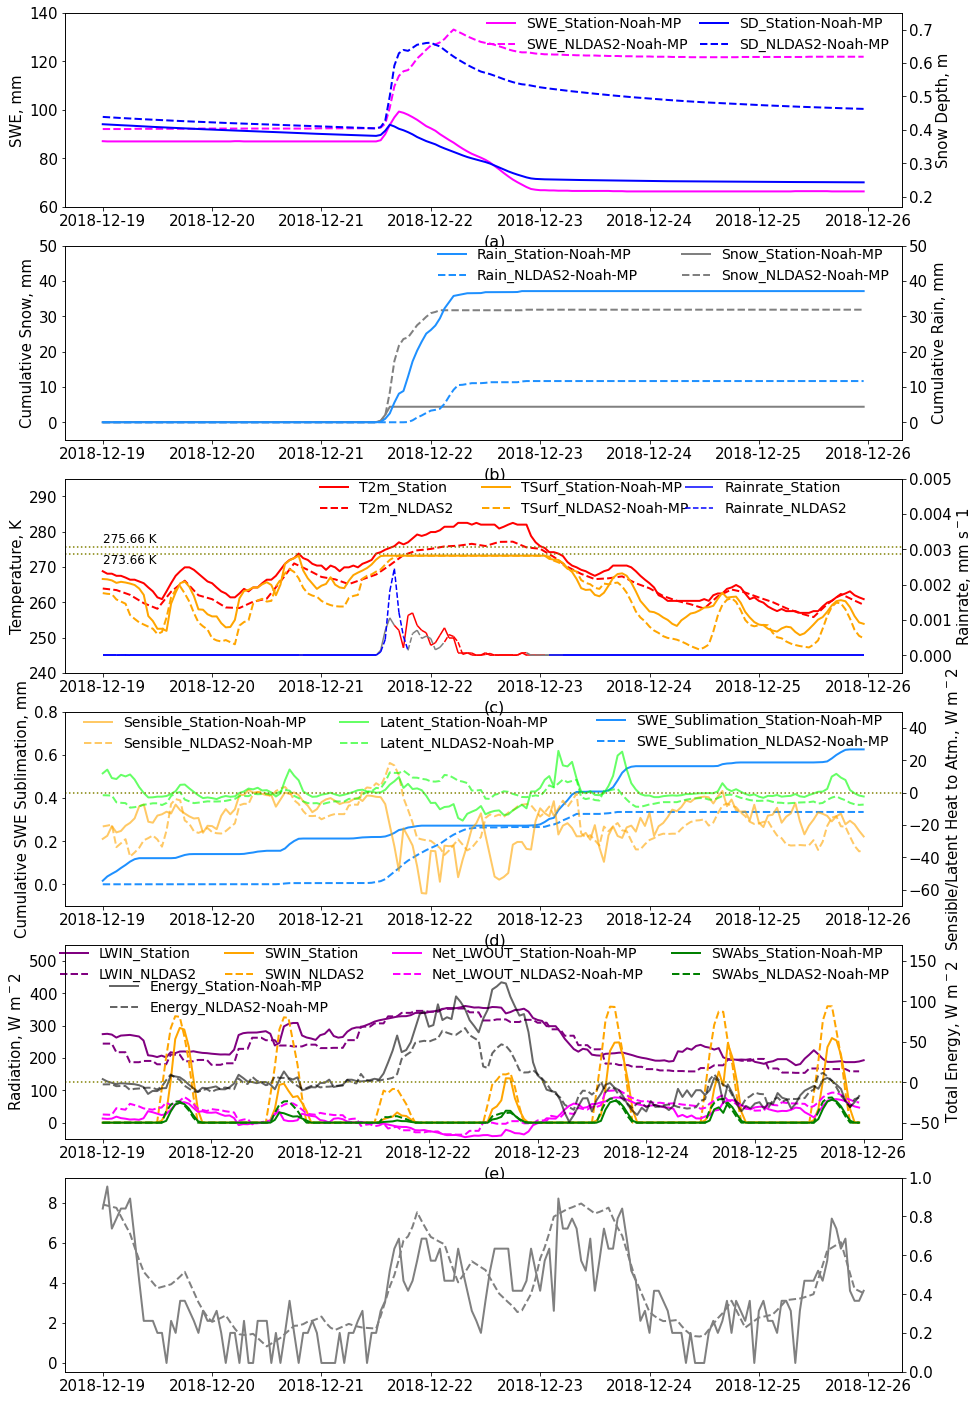

In [11]:
fig = plt.figure(figsize=(15,25))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots()
matplotlib.rcParams.update({'font.size': 15})

ax0 = plt.subplot(6,1,1)
ax0.plot("Time","SNEQV",data=STATION_df[43512:43680], marker='', color='magenta', linewidth=2);
ax0.plot("Time","SNEQV",data=NLDAS_df[43512:43680], marker='', color='magenta', linewidth=2,linestyle='dashed');
ax0.set_ylabel('SWE, mm')
#ax0.set_xlabel('Date')
ax0.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax0.set_ylim(60,140)
ax0.legend(['SWE_Station-Noah-MP','SWE_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.89),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(a)',transform=ax0.transAxes,fontsize="16")
ax00=ax0.twinx()
#ax00.spines["right"].set_position(("axes", 1.01))
ax00.plot("Time","SNOWH",data=STATION_df[43512:43680], marker='', color='blue', linewidth=2);
ax00.plot("Time","SNOWH",data=NLDAS_df[43512:43680], marker='', color='blue', linewidth=2, linestyle='dashed');
ax00.legend(['SD_Station-Noah-MP','SD_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.89),loc=5,fontsize='14',frameon=False, ncol=1)
ax00.set_ylabel('Snow Depth, m')
ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.set_ylim(0.17,0.75)

ax1 = plt.subplot(6,1,5)
#ax1.plot("time","SNEQV",data=da_WY19,marker='', markerfacecolor='olive', markersize=12, color='olive', linewidth=4);
ax1.plot("DATE_TIME_UTC","IR01UpCo_Avg",data=SAFE_F.loc[43512:43680],marker='', color='purple', linewidth=2);
ax1.plot("Times","LWDOWN",data=NLDAS_F[43512:43680], marker='', color='purple', linewidth=2,linestyle='dashed');
ax1.plot("DATE_TIME_UTC","SR01Dn_Avg",data=SAFE_F[43512:43680], marker='', color='orange', linewidth=2);
ax1.plot("Times","SWDOWN",data=NLDAS_F[43512:43680], marker='', color='orange', linewidth=2,linestyle='dashed');
ax1.plot("Time","FIRA",data=STATION_df[43512:43680], marker='', color='magenta', linewidth=2);
ax1.plot("Time","FIRA",data=NLDAS_df[43512:43680], marker='', color='magenta', linewidth=2, linestyle='dashed');
ax1.plot("Time","FSA",data=STATION_df[43512:43680], marker='', color='green', linewidth=2);
ax1.plot("Time","FSA",data=NLDAS_df[43512:43680], marker='', color='green', linewidth=2, linestyle='dashed');
ax1.set_ylabel('Radiation, W m$^-2$')
plt.ylim(-50,550)
#ax1.set_xlabel('Date')
ax1.legend(['LWIN_Station','LWIN_NLDAS2','SWIN_Station','SWIN_NLDAS2','Net_LWOUT_Station-Noah-MP','Net_LWOUT_NLDAS2-Noah-MP','SWAbs_Station-Noah-MP','SWAbs_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14', frameon=False, ncol=4)
text(0.5,-0.2,'(e)',transform=ax1.transAxes,fontsize="16")
ax11=ax1.twinx()
ax11.plot("Time","Tot_Energy",data=STATION_12_18_df, marker='', color='black', alpha=0.6,linewidth=2);
ax11.plot("Time","Tot_Energy",data=NLDAS_12_18_df, marker='', color='black', alpha=0.6, linewidth=2, linestyle='dashed');
plt.ylim(-70,170)
ax11.set_ylabel('Total Energy, W m$^-2$')
ax11.axhline(y=0, color='olive', linestyle='dotted')
ax11.legend(['Energy_Station-Noah-MP','Energy_NLDAS2-Noah-MP'],bbox_to_anchor=(0.33,0.73),loc=5,fontsize='14',frameon=False,ncol=1)

ax2 = plt.subplot(6,1,2)
ax2.plot("Date","SAFE_CumSnow_zeroed",data=rainsnow_dec, marker='', color='grey', linewidth=2);
ax2.plot("Date","NLDAS_CumSnow_zeroed",data=rainsnow_dec, marker='', color='grey', linewidth=2, linestyle='dashed');
ax21=ax2.twinx()
ax21.plot("Date","SAFE_CumRain_zeroed",data=rainsnow_dec, marker='', color='dodgerblue', linewidth=2);
ax21.plot("Date","NLDAS_CumRain_zeroed",data=rainsnow_dec, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
ax2.set_ylabel("Cumulative Snow, mm")
ax21.set_ylabel("Cumulative Rain, mm")
ax2.set_ylim( -5,50)
ax21.set_ylim( -5,50)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax21.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.legend(['Snow_Station-Noah-MP','Snow_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
ax21.legend(['Rain_Station-Noah-MP','Rain_NLDAS2-Noah-MP'],bbox_to_anchor=(0.70,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(b)',transform=ax2.transAxes,fontsize="16")

ax5 = plt.subplot(6,1,4)
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=STATION_12_18_df, marker='', color='dodgerblue', linewidth=2);
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=NLDAS_12_18_df, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax5.set_ylim(-0.1,0.8)
ax5.set_ylabel("Cumulative SWE Sublimation, mm")
ax5.legend(['SWE_Sublimation_Station-Noah-MP','SWE_Sublimation_NLDAS2-Noah-MP',],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(d)',transform=ax5.transAxes,fontsize="16")
ax51=ax5.twinx()
ax51.plot("Time","HFX",data=STATION_12_18_df, marker='', color='orange', alpha=0.6,linewidth=2);
ax51.plot("Time","HFX",data=NLDAS_12_18_df, marker='', color='orange', alpha=0.6,linewidth=2, linestyle='dashed');
ax51.plot("Time","LH",data=STATION_12_18_df, marker='', color='lime', alpha=0.6,linewidth=2);
ax51.plot("Time","LH",data=NLDAS_12_18_df, marker='', color='lime', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.set_ylabel("Sensible/Latent Heat to Atm., W m$^-2$")
ax51.set_ylim( -70,50)
ax51.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax51.legend(['Sensible_Station-Noah-MP','Sensible_NLDAS2-Noah-MP','Latent_Station-Noah-MP','Latent_NLDAS2-Noah-MP'],bbox_to_anchor=(0.6,0.89),loc=5,fontsize='14',frameon=False,ncol=2)
ax51.axhline(y=0, color='olive', linestyle='dotted')

ax3 = plt.subplot(6,1,3)
ax3.plot("DATE_TIME_UTC","AIR_T[K]",data=SAFE_F[43512:43680], marker='', color='red', linewidth=2);
ax3.plot("Times","T2D",data=NLDAS_F[43512:43680], marker='', color='red', linewidth=2, linestyle='dashed');
ax3.plot("Time","TRAD",data=STATION_df[43512:43680], marker='', color='orange', linewidth=2);
ax3.plot("Time","TRAD",data=NLDAS_df[43512:43680], marker='', color='orange', linewidth=2, linestyle='dashed');
#ax3.set_xlabel('Date')
ax3.set_ylabel("Temperature, K")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.set_ylim(240,295)
ax3.axhline(y=273.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-12-19"), 271, '273.66 K',fontsize=12)
ax3.axhline(y=275.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-12-19"), 277, '275.66 K',fontsize=12)
ax3.legend(['T2m_Station','T2m_NLDAS2','TSurf_Station-Noah-MP','TSurf_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.90),loc=5,fontsize='14',frameon=False, ncol=2)
text(0.5,-0.2,'(c)',transform=ax3.transAxes,fontsize="16")
ax31=ax3.twinx()

colors2=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in SAFE_F.iloc[43512:43680,:]['AIR_T[K]']]
x2 = mpd.date2num(SAFE_F.iloc[43512:43680,:]['DATE_TIME_UTC'])
y2 = SAFE_F.iloc[43512:43680,:]['PR01[mm/s]'].values
points2 = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
lc2 = LineCollection(segments2, colors=colors2)

colors3=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in NLDAS_F.iloc[43512:43680,:]['T2D']]
x3 = mpd.date2num(NLDAS_F.iloc[43512:43680,:]['Times'])
y3 = NLDAS_F.iloc[43512:43680,:]['RAINRATE'].values
points3 = np.array([x3, y3]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
lc3 = LineCollection(segments3, colors=colors3,linestyle='dashed')

ax31.add_collection(lc2)
ax31.add_collection(lc3)
ax31.autoscale()

ax31.set_ylabel("Rainrate, mm s$^-1$")
ax31.set_ylim(-0.0005,0.005)
ax31.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax31.legend(['Rainrate_Station','Rainrate_NLDAS2'],bbox_to_anchor=(0.95,0.90),loc=5, fontsize='14',frameon=False)
           
ax4 = plt.subplot(6,1,6)
ax4.plot("DATE_TIME_UTC","WSPD[m/s]",data=SAFE_F[43512:43680], marker='', color='gray', linewidth=2);
ax4.plot("Times","UV_Wind[m/s]",data=NLDAS_F[43512:43680], marker='', color='gray', linewidth=2, linestyle='dashed');
ax41=ax4.twinx()
#ax31.spines["right"].set_position(("axes", 1.01))
ax41.plot("Time","ALBEDO_updated",data=STATION_df[43512:43680], marker='', color='orange', linewidth=2);
ax41.plot("Time","ALBEDO_updated",data=NLDAS_df[43512:43680], marker='', color='orange', linewidth=2, linestyle='dashed');
ax4.set_xlabel('Date')
ax4.set_ylabel("Wind, m s$^-2$")
ax4.set_ylim(-0.5,12)
ax4.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax41.set_ylabel("Albedo")
ax41.set_ylim(-0.05,1.1)
ax41.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax4.legend(['Wind_Station','Wind_NLDAS2'],bbox_to_anchor=(0.72,0.89),loc=5,fontsize='14',frameon=False, ncol=1)
ax41.legend(['Albedo_Station-Noah-MP','Albedo_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.25,'(f)',transform=ax4.transAxes,fontsize="16")
fig.tight_layout()

plt.show()
fig.savefig('Figure6.jpeg',bbox_inches='tight',dpi=1600)

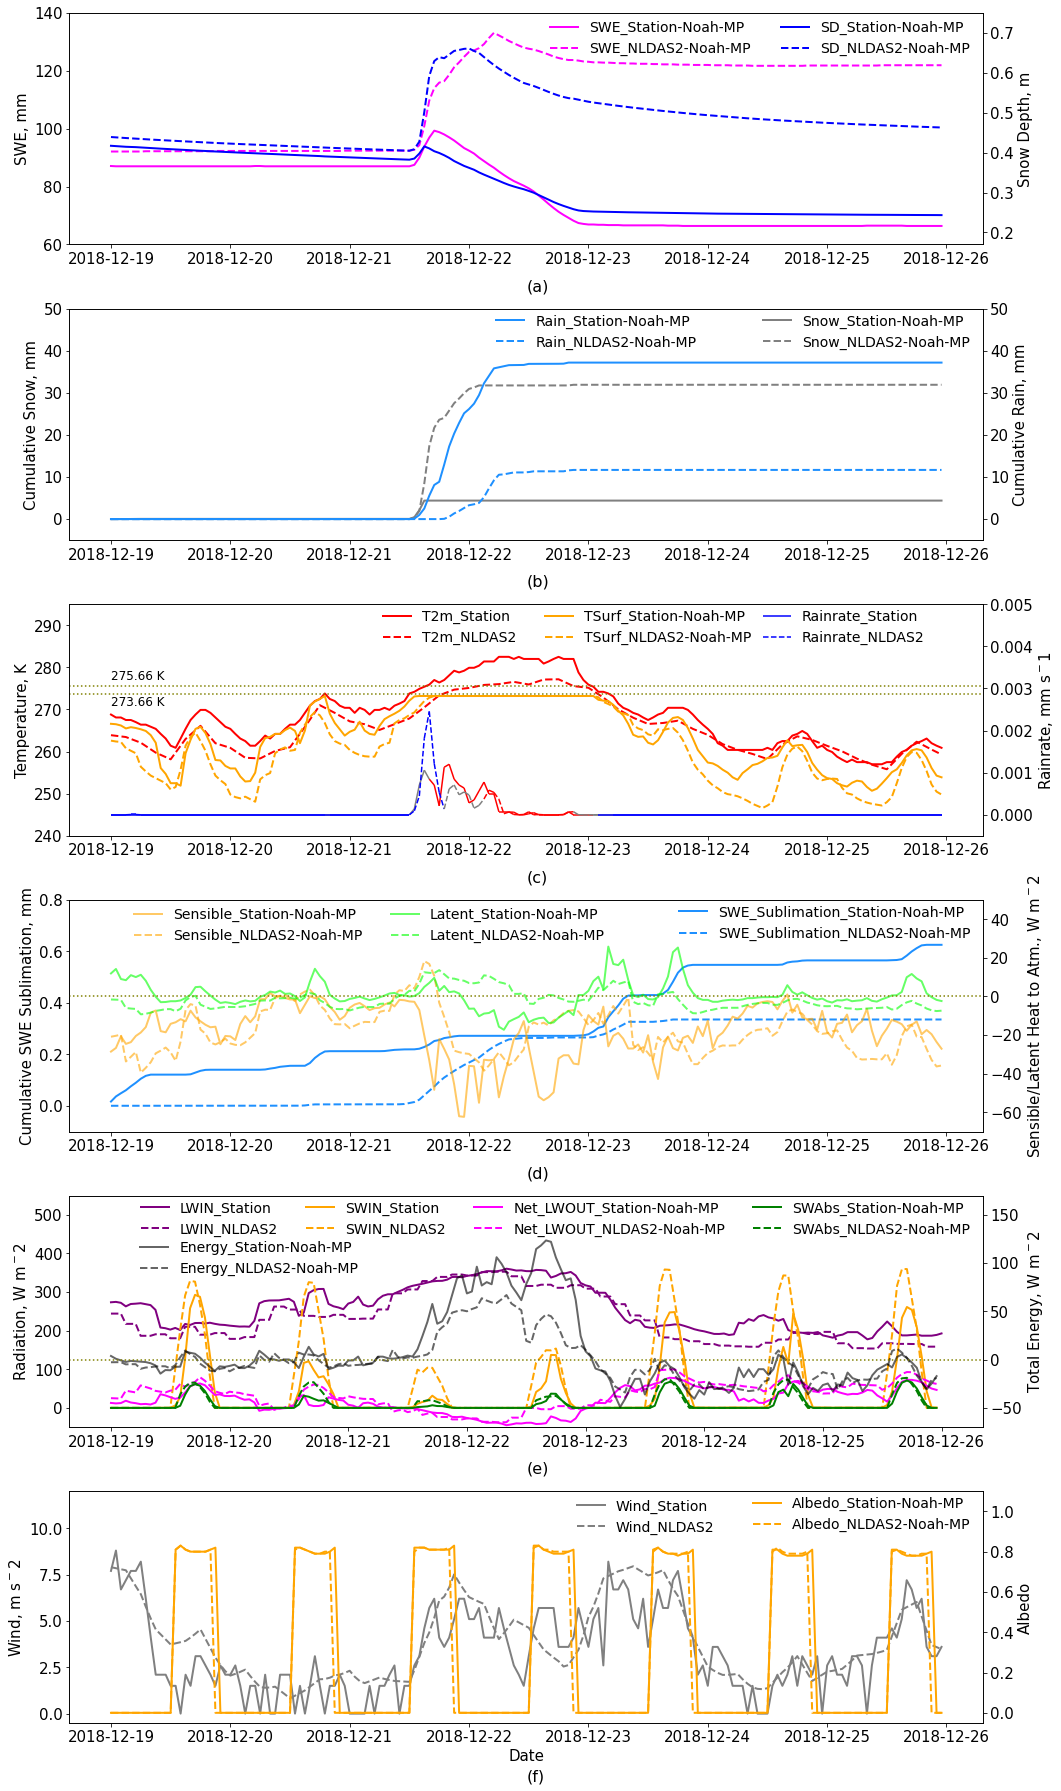

In [25]:
fig = plt.figure(figsize=(15,25))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots()
matplotlib.rcParams.update({'font.size': 15})

ax0 = plt.subplot(6,1,1)
ax0.plot("Time","SNEQV",data=STATION_df[43512:43680], marker='', color='magenta', linewidth=2);
ax0.plot("Time","SNEQV",data=NLDAS_df[43512:43680], marker='', color='magenta', linewidth=2,linestyle='dashed');
ax0.set_ylabel('SWE, mm')
#ax0.set_xlabel('Date')
ax0.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax0.set_ylim(60,140)
ax0.legend(['SWE_Station-Noah-MP','SWE_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.89),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(a)',transform=ax0.transAxes,fontsize="16")
ax00=ax0.twinx()
#ax00.spines["right"].set_position(("axes", 1.01))
ax00.plot("Time","SNOWH",data=STATION_df[43512:43680], marker='', color='blue', linewidth=2);
ax00.plot("Time","SNOWH",data=NLDAS_df[43512:43680], marker='', color='blue', linewidth=2, linestyle='dashed');
ax00.legend(['SD_Station-Noah-MP','SD_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.89),loc=5,fontsize='14',frameon=False, ncol=1)
ax00.set_ylabel('Snow Depth, m')
ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax00.set_ylim(0.17,0.75)

ax1 = plt.subplot(6,1,5)
#ax1.plot("time","SNEQV",data=da_WY19,marker='', markerfacecolor='olive', markersize=12, color='olive', linewidth=4);
ax1.plot("DATE_TIME_UTC","IR01UpCo_Avg",data=SAFE_F.loc[43512:43680],marker='', color='purple', linewidth=2);
ax1.plot("Times","LWDOWN",data=NLDAS_F[43512:43680], marker='', color='purple', linewidth=2,linestyle='dashed');
ax1.plot("DATE_TIME_UTC","SR01Dn_Avg",data=SAFE_F[43512:43680], marker='', color='orange', linewidth=2);
ax1.plot("Times","SWDOWN",data=NLDAS_F[43512:43680], marker='', color='orange', linewidth=2,linestyle='dashed');
ax1.plot("Time","FIRA",data=STATION_df[43512:43680], marker='', color='magenta', linewidth=2);
ax1.plot("Time","FIRA",data=NLDAS_df[43512:43680], marker='', color='magenta', linewidth=2, linestyle='dashed');
ax1.plot("Time","FSA",data=STATION_df[43512:43680], marker='', color='green', linewidth=2);
ax1.plot("Time","FSA",data=NLDAS_df[43512:43680], marker='', color='green', linewidth=2, linestyle='dashed');
ax1.set_ylabel('Radiation, W m$^-2$')
plt.ylim(-50,550)
#ax1.set_xlabel('Date')
ax1.legend(['LWIN_Station','LWIN_NLDAS2','SWIN_Station','SWIN_NLDAS2','Net_LWOUT_Station-Noah-MP','Net_LWOUT_NLDAS2-Noah-MP','SWAbs_Station-Noah-MP','SWAbs_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14', frameon=False, ncol=4)
text(0.5,-0.2,'(e)',transform=ax1.transAxes,fontsize="16")
ax11=ax1.twinx()
ax11.plot("Time","Tot_Energy",data=STATION_12_18_df, marker='', color='black', alpha=0.6,linewidth=2);
ax11.plot("Time","Tot_Energy",data=NLDAS_12_18_df, marker='', color='black', alpha=0.6, linewidth=2, linestyle='dashed');
plt.ylim(-70,170)
ax11.set_ylabel('Total Energy, W m$^-2$')
ax11.axhline(y=0, color='olive', linestyle='dotted')
ax11.legend(['Energy_Station-Noah-MP','Energy_NLDAS2-Noah-MP'],bbox_to_anchor=(0.33,0.73),loc=5,fontsize='14',frameon=False,ncol=1)

ax2 = plt.subplot(6,1,2)
ax2.plot("Date","SAFE_CumSnow_zeroed",data=rainsnow_dec, marker='', color='grey', linewidth=2);
ax2.plot("Date","NLDAS_CumSnow_zeroed",data=rainsnow_dec, marker='', color='grey', linewidth=2, linestyle='dashed');
ax21=ax2.twinx()
ax21.plot("Date","SAFE_CumRain_zeroed",data=rainsnow_dec, marker='', color='dodgerblue', linewidth=2);
ax21.plot("Date","NLDAS_CumRain_zeroed",data=rainsnow_dec, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
ax2.set_ylabel("Cumulative Snow, mm")
ax21.set_ylabel("Cumulative Rain, mm")
ax2.set_ylim( -5,50)
ax21.set_ylim( -5,50)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax21.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.legend(['Snow_Station-Noah-MP','Snow_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
ax21.legend(['Rain_Station-Noah-MP','Rain_NLDAS2-Noah-MP'],bbox_to_anchor=(0.70,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(b)',transform=ax2.transAxes,fontsize="16")

ax5 = plt.subplot(6,1,4)
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=STATION_12_18_df, marker='', color='dodgerblue', linewidth=2);
ax5.plot("Time","dSWE_sublime_cum_zeroed",data=NLDAS_12_18_df, marker='', color='dodgerblue', linewidth=2, linestyle='dashed');
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax5.set_ylim(-0.1,0.8)
ax5.set_ylabel("Cumulative SWE Sublimation, mm")
ax5.legend(['SWE_Sublimation_Station-Noah-MP','SWE_Sublimation_NLDAS2-Noah-MP',],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(d)',transform=ax5.transAxes,fontsize="16")
ax51=ax5.twinx()
ax51.plot("Time","HFX",data=STATION_12_18_df, marker='', color='orange', alpha=0.6,linewidth=2);
ax51.plot("Time","HFX",data=NLDAS_12_18_df, marker='', color='orange', alpha=0.6,linewidth=2, linestyle='dashed');
ax51.plot("Time","LH",data=STATION_12_18_df, marker='', color='lime', alpha=0.6,linewidth=2);
ax51.plot("Time","LH",data=NLDAS_12_18_df, marker='', color='lime', alpha=0.6, linewidth=2, linestyle='dashed');
ax51.set_ylabel("Sensible/Latent Heat to Atm., W m$^-2$")
ax51.set_ylim( -70,50)
ax51.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax51.legend(['Sensible_Station-Noah-MP','Sensible_NLDAS2-Noah-MP','Latent_Station-Noah-MP','Latent_NLDAS2-Noah-MP'],bbox_to_anchor=(0.6,0.89),loc=5,fontsize='14',frameon=False,ncol=2)
ax51.axhline(y=0, color='olive', linestyle='dotted')

ax3 = plt.subplot(6,1,3)
ax3.plot("DATE_TIME_UTC","AIR_T[K]",data=SAFE_F[43512:43680], marker='', color='red', linewidth=2);
ax3.plot("Times","T2D",data=NLDAS_F[43512:43680], marker='', color='red', linewidth=2, linestyle='dashed');
ax3.plot("Time","TRAD",data=STATION_df[43512:43680], marker='', color='orange', linewidth=2);
ax3.plot("Time","TRAD",data=NLDAS_df[43512:43680], marker='', color='orange', linewidth=2, linestyle='dashed');
#ax3.set_xlabel('Date')
ax3.set_ylabel("Temperature, K")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.set_ylim(240,295)
ax3.axhline(y=273.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-12-19"), 271, '273.66 K',fontsize=12)
ax3.axhline(y=275.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-12-19"), 277, '275.66 K',fontsize=12)
ax3.legend(['T2m_Station','T2m_NLDAS2','TSurf_Station-Noah-MP','TSurf_NLDAS2-Noah-MP'],bbox_to_anchor=(0.76,0.90),loc=5,fontsize='14',frameon=False, ncol=2)
text(0.5,-0.2,'(c)',transform=ax3.transAxes,fontsize="16")
ax31=ax3.twinx()

colors2=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in SAFE_F.iloc[43512:43680,:]['AIR_T[K]']]
x2 = mpd.date2num(SAFE_F.iloc[43512:43680,:]['DATE_TIME_UTC'])
y2 = SAFE_F.iloc[43512:43680,:]['PR01[mm/s]'].values
points2 = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
lc2 = LineCollection(segments2, colors=colors2)

colors3=['grey' if 273.66 < x <= 275.66 else 'red' if x > 275.66 else 'blue' for x in NLDAS_F.iloc[43512:43680,:]['T2D']]
x3 = mpd.date2num(NLDAS_F.iloc[43512:43680,:]['Times'])
y3 = NLDAS_F.iloc[43512:43680,:]['RAINRATE'].values
points3 = np.array([x3, y3]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
lc3 = LineCollection(segments3, colors=colors3,linestyle='dashed')

ax31.add_collection(lc2)
ax31.add_collection(lc3)
ax31.autoscale()

ax31.set_ylabel("Rainrate, mm s$^-1$")
ax31.set_ylim(-0.0005,0.005)
ax31.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax31.legend(['Rainrate_Station','Rainrate_NLDAS2'],bbox_to_anchor=(0.95,0.90),loc=5, fontsize='14',frameon=False)
           
ax4 = plt.subplot(6,1,6)
ax4.plot("DATE_TIME_UTC","WSPD[m/s]",data=SAFE_F[43512:43680], marker='', color='gray', linewidth=2);
ax4.plot("Times","UV_Wind[m/s]",data=NLDAS_F[43512:43680], marker='', color='gray', linewidth=2, linestyle='dashed');
ax41=ax4.twinx()
#ax31.spines["right"].set_position(("axes", 1.01))
ax41.plot("Time","ALBEDO_updated",data=STATION_df[43512:43680], marker='', color='orange', linewidth=2);
ax41.plot("Time","ALBEDO_updated",data=NLDAS_df[43512:43680], marker='', color='orange', linewidth=2, linestyle='dashed');
ax4.set_xlabel('Date')
ax4.set_ylabel("Wind, m s$^-2$")
ax4.set_ylim(-0.5,12)
ax4.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax41.set_ylabel("Albedo")
ax41.set_ylim(-0.05,1.1)
ax41.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax4.legend(['Wind_Station','Wind_NLDAS2'],bbox_to_anchor=(0.72,0.89),loc=5,fontsize='14',frameon=False, ncol=1)
ax41.legend(['Albedo_Station-Noah-MP','Albedo_NLDAS2-Noah-MP'],bbox_to_anchor=(1,0.90),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.25,'(f)',transform=ax4.transAxes,fontsize="16")
fig.tight_layout()

plt.show()
fig.savefig('Figure6.jpeg',bbox_inches='tight',dpi=1600)

In [185]:
NLDAS_12_18_df

,index,Unnamed: 0,Time,HFX,LH,dSWE_sublime,dSWE_sublime_updated,dSWE_sublime_cum,dSWE_sublime_cum_zeroed,FSA,FIRA,Tot_Energy
0,432,432,2018-12-19 00:00:00,-20.900000,-1.6,-0.002221,0.0,0.000000,0.000000,0.000000,25.200000,-2.7
1,433,433,2018-12-19 01:00:00,-20.400000,-1.7,-0.002360,0.0,0.000000,0.000000,0.000000,24.700000,-2.6
2,434,434,2018-12-19 02:00:00,-19.800000,-1.8,-0.002499,0.0,0.000000,0.000000,0.000000,24.200000,-2.6
3,435,435,2018-12-19 03:00:00,-33.700001,-6.0,-0.008329,0.0,0.000000,0.000000,0.000000,44.600001,-4.9
4,436,436,2018-12-19 04:00:00,-31.300000,-6.3,-0.008746,0.0,0.000000,0.000000,0.000000,42.300001,-4.7
...,...,...,...,...,...,...,...,...,...,...,...,...
163,595,595,2018-12-25 19:00:00,-21.100000,-4.7,-0.006525,0.0,0.335252,0.335252,43.600001,85.800001,-16.4
164,596,596,2018-12-25 20:00:00,-27.200000,-6.3,-0.008746,0.0,0.335252,0.335252,19.000000,75.900001,-23.4
165,597,597,2018-12-25 21:00:00,-32.900000,-7.2,-0.009995,0.0,0.335252,0.335252,0.000000,70.900001,-30.8
166,598,598,2018-12-25 22:00:00,-36.300001,-7.6,-0.010550,0.0,0.335252,0.335252,0.000000,64.800001,-20.9


In [30]:
SAFE_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     52584 non-null  int64         
 1   DATE_TIME_UTC  52584 non-null  datetime64[ns]
 2   DATE_TIME_EST  52584 non-null  object        
 3   AIR_T[C]       51528 non-null  float64       
 4   WSPD[m/s]      51528 non-null  float64       
 5   RH[%]          51528 non-null  object        
 6   SR01Up_Avg     37824 non-null  float64       
 7   IR01UpCo_Avg   37824 non-null  float64       
 8   SR01Dn_Avg     37824 non-null  float64       
 9   IR01DnCo_Avg   37824 non-null  float64       
 10  Albedo_Avg     6290 non-null   float64       
 11  PR01[m]        51528 non-null  float64       
 12  PR01[mm/s]     51528 non-null  float64       
 13  AIR_T[K]       51528 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(2)
memory usage: 5

In [31]:
NLDAS_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    52584 non-null  int64         
 1   LWDOWN        52584 non-null  float64       
 2   PSFC          52584 non-null  float64       
 3   Q2D           52584 non-null  float64       
 4   RAINRATE      52584 non-null  float64       
 5   SWDOWN        52584 non-null  float64       
 6   T2D           52584 non-null  float64       
 7   Times         52584 non-null  datetime64[ns]
 8   U2D           52584 non-null  float64       
 9   V2D           52584 non-null  float64       
 10  valid time    52584 non-null  int64         
 11  year          52584 non-null  int64         
 12  month         52584 non-null  int64         
 13  day           52584 non-null  int64         
 14  hour          52584 non-null  int64         
 15  Rain(m)       52584 non-null  float6

In [33]:
STATION_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      52584 non-null  int64         
 1   Time            52584 non-null  datetime64[ns]
 2   SNOWH           52584 non-null  float64       
 3   SNEQV           52584 non-null  float64       
 4   ALBEDO          52570 non-null  float64       
 5   FSNO            52583 non-null  float64       
 6   FIRA            52583 non-null  float64       
 7   FSA             52583 non-null  float64       
 8   TRAD            52583 non-null  float64       
 9   LWUP            37823 non-null  float64       
 10  SWUP            37823 non-null  float64       
 11  ALBEDO_updated  52584 non-null  float64       
 12  FSA_updated     52584 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 5.2 MB


In [34]:
NLDAS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      52584 non-null  int64         
 1   Time            52584 non-null  datetime64[ns]
 2   SNOWH           52584 non-null  float64       
 3   SNEQV           52584 non-null  float64       
 4   ALBEDO          52570 non-null  float64       
 5   FSNO            52583 non-null  float64       
 6   FSA             52583 non-null  float64       
 7   FIRA            52583 non-null  float64       
 8   TRAD            52583 non-null  float64       
 9   LWUP            52583 non-null  float64       
 10  SWUP            52583 non-null  float64       
 11  ALBEDO_updated  52583 non-null  float64       
 12  FSA_updated     52584 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 5.2 MB


In [35]:
SNOW_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     52584 non-null  int64         
 1   DATE_TIME_UTC  52584 non-null  object        
 2   DATE_TIME_EST  52584 non-null  object        
 3   SWE_K[kg/m2]   32274 non-null  float64       
 4   SnowDepth[m]   37387 non-null  float64       
 5   SND[m]         52573 non-null  float64       
 6   Date           52584 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.8+ MB


In [63]:
SAFE_F[42700:43050].head()

,Unnamed: 0,DATE_TIME_UTC,DATE_TIME_EST,AIR_T[C],WSPD[m/s],RH[%],SR01Up_Avg,IR01UpCo_Avg,SR01Dn_Avg,IR01DnCo_Avg,Albedo_Avg,PR01[m],PR01[mm/s],AIR_T[K]
42700,7636,2018-11-15 04:00:00,2018/11/14 23:00:00,-10.05,4.1,61,0.0,191.22,0.52,254.57,NaN,0.0,0.0,263.1
42701,7637,2018-11-15 05:00:00,2018/11/15 00:00:00,-10.05,3.6,58,0.0,199.67,0.29,255.92,NaN,0.0,0.0,263.1
42702,7638,2018-11-15 06:00:00,2018/11/15 01:00:00,-10.65,5.1,61,0.0,193.08,0.51,252.90,NaN,0.0,0.0,262.5
42703,7639,2018-11-15 07:00:00,2018/11/15 02:00:00,-10.65,5.7,64,0.0,189.93,0.35,254.50,NaN,0.0,0.0,262.5
42704,7640,2018-11-15 08:00:00,2018/11/15 03:00:00,-11.15,4.1,66,0.0,189.48,0.39,253.32,NaN,0.0,0.0,262.0


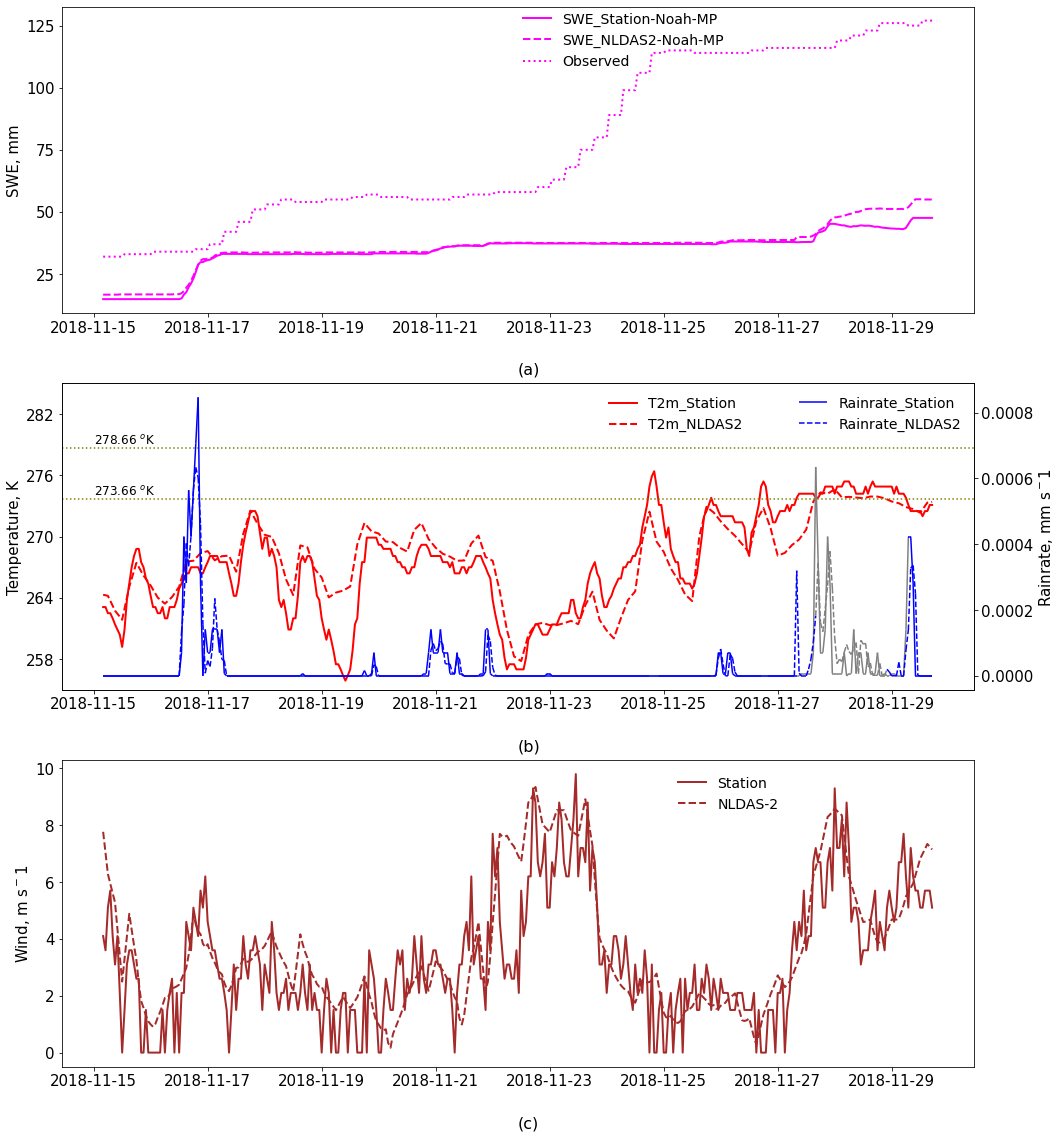

In [11]:
fig = plt.figure(figsize=(15,16))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots()
matplotlib.rcParams.update({'font.size': 15})

ax0 = plt.subplot(3,1,1)
ax0.plot("Time","SNEQV",data=STATION_df[42700:43050], marker='', color='magenta', linewidth=2);
ax0.plot("Time","SNEQV",data=NLDAS_df[42700:43050], marker='', color='magenta', linewidth=2,linestyle='dashed');
ax0.plot("Date","SWE_K[kg/m2]",data=SNOW_st[42700:43050], marker='', color='magenta', linewidth=2,linestyle='dotted');
ax0.set_ylabel('SWE, mm')
#ax0.set_xlabel('Date')
ax0.yaxis.set_major_locator(ticker.MultipleLocator(25))
#ax0.set_ylim(60,140)
ax0.legend(['SWE_Station-Noah-MP','SWE_NLDAS2-Noah-MP','Observed'],bbox_to_anchor=(0.74,0.89),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(a)',transform=ax0.transAxes,fontsize="16")

ax3 = plt.subplot(3,1,2)
ax3.plot("DATE_TIME_UTC","AIR_T[K]",data=SAFE_F[42700:43050], marker='', color='red', linewidth=2);
ax3.plot("Times","T2D",data=NLDAS_F[42700:43050], marker='', color='red', linewidth=2, linestyle='dashed');
#ax3.set_xlabel('Date')
ax3.set_ylabel("Temperature, K")
ax3.yaxis.set_major_locator(ticker.MultipleLocator(6))
ax3.set_ylim(255,285)
ax3.axhline(y=273.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-15"), 274, '273.66 $^o$K',fontsize=12)
ax3.axhline(y=278.66, color='olive', linestyle='dotted')
ax3.text(Timestamp("2018-11-15"), 279, '278.66 $^o$K',fontsize=12)
ax3.legend(['T2m_Station','T2m_NLDAS2'],bbox_to_anchor=(0.76,0.90),loc=5,fontsize='14',frameon=False, ncol=1)
text(0.5,-0.2,'(b)',transform=ax3.transAxes,fontsize="16")
ax31=ax3.twinx()

colors2=['grey' if 273.66 < x <= 278.66 else 'red' if x > 278.66 else 'blue' for x in SAFE_F.iloc[42700:43050,:]['AIR_T[K]']]
x2 = mpd.date2num(SAFE_F.iloc[42700:43050,:]['DATE_TIME_UTC'])
y2 = SAFE_F.iloc[42700:43050,:]['PR01[mm/s]'].values
points2 = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
lc2 = LineCollection(segments2, colors=colors2)

colors3=['grey' if 273.66 < x <= 278.66 else 'red' if x > 278.66 else 'blue' for x in NLDAS_F.iloc[42700:43050,:]['T2D']]
x3 = mpd.date2num(NLDAS_F.iloc[42700:43050,:]['Times'])
y3 = NLDAS_F.iloc[42700:43050,:]['RAINRATE'].values
points3 = np.array([x3, y3]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
lc3 = LineCollection(segments3, colors=colors3,linestyle='dashed')

ax31.add_collection(lc2)
ax31.add_collection(lc3)
ax31.autoscale()

ax31.set_ylabel("Rainrate, mm s$^-1$")
#ax31.set_ylim(-0.0005,0.005)
#ax31.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
ax31.legend(['Rainrate_Station','Rainrate_NLDAS2'],fontsize='14',frameon=False)


ax4 = plt.subplot(3,1,3)
ax4.plot("DATE_TIME_UTC","WSPD[m/s]",data=SAFE_F[42700:43050], marker='', color='brown', linewidth=2);
ax4.plot("Times","UV_Wind[m/s]",data=NLDAS_F[42700:43050], marker='', color='brown', linewidth=2,linestyle='dashed');
ax4.set_ylabel('Wind, m s$^-1$')
#ax0.set_xlabel('Date')
ax4.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax4.set_ylim(60,140)
ax4.legend(['Station','NLDAS-2'],bbox_to_anchor=(0.80,0.89),loc=5,fontsize='14',frameon=False,ncol=1)
text(0.5,-0.2,'(c)',transform=ax4.transAxes,fontsize="16")
fig.tight_layout()
plt.show()
fig.savefig('Figure8.jpeg',bbox_inches='tight',dpi=1600)
